In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import numpy as np
import mygene
import gtfparse
mg = mygene.MyGeneInfo()

import pyensembl
pyensembl.EnsemblRelease(release=87)

from Bio import SeqIO

from collections import Counter

In [3]:
biomart = pd.read_csv('../biomart_human.txt', delimiter='\t')
biomart['length'] = biomart['Transcript length (including UTRs and CDS)']
biomart['tid'] = biomart['Transcript stable ID']
biomart.columns

Index([u'Gene stable ID', u'Transcript stable ID', u'Transcript name',
       u'Gene name', u'GENCODE basic annotation',
       u'Transcript length (including UTRs and CDS)', u'WikiGene description',
       u'length', u'tid'],
      dtype='object')

In [5]:
stringtie_counts = gtfparse.read_gtf('SRR786495.isoforms')
stringtie_counts = stringtie_counts[stringtie_counts.feature=='transcript']
stringtie_counts = stringtie_counts[['transcript_id', 'gene_id', 'ref_gene_name', 'cov', 'FPKM', 'TPM']]

stringtie_counts['gene_id'] = [i.split('.')[0] for i in stringtie_counts['gene_id']]
stringtie_counts['FPKM'] = stringtie_counts.FPKM.astype(float)
stringtie_counts['TPM'] = stringtie_counts.TPM.astype(float)
stringtie_counts.sort_values(['ref_gene_name', 'FPKM'], inplace=True, ascending=False)
stringtie_counts['transcript_id'] = [i.split('.')[0] for i in stringtie_counts['transcript_id']]


#stringtie_counts = stringtie_counts[stringtie_counts.transcript_id.isin(biomart['Transcript stable ID'])]


# for idx, tid in stringtie_counts.transcript_id.iteritems():
#     try:
#         length = sum(np.diff(pyensembl.ensembl_grch38.transcript_by_id(tid.split('.')[0]).exon_intervals))[0]
#         tid_length[tid] = length
#     except:
#         print(tid)
#         length=np.nan
#     stringtie_counts.set_value(idx, 'length', length)
# tid_version_map = {i.split('.')[0]: i.split('.')[1] for i in stringtie_counts.transcript_id.values}

INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'ref_gene_name', 'cov', 'FPKM', 'TPM', 'exon_number', 'gene_name']


In [6]:
def select_best_isoform(isodf, columns = {'length': 'l',
                                          'isofract': 'isofract', 
                                          'expression': 'FPKM'}, 
                       accepted_length=3000):
    isodf = isodf.sort_values([columns['isofract'], columns['length']], ascending=False)
    length_sort = np.argsort(isodf[columns['length']].values)[::-1]
    length_ranks = np.empty_like(length_sort)
    length_ranks[length_sort] = np.arange(len(length_sort))
    #length_rank = np.argsort(isodf[columns['length']])[::-1]
    isodf['lrank'] = length_ranks
    #pdb.set_trace()
    if isodf.iloc[0]['lrank']==0:
        return isodf.iloc[0]
    elif isodf.iloc[0][columns['length']] >= accepted_length:
        
        return isodf.iloc[0]
    else:
        return isodf.iloc[:3].sort_values('lrank').iloc[0]
        
        

In [170]:
stringtie_counts = stringtie_counts[stringtie_counts.gene_id.isin(catable.Ensembl)]

In [179]:
stringtie_counts[stringtie_counts.gene_id=='ENSG00000151689']

,transcript_id,gene_id,ref_gene_name,cov,FPKM,TPM
190901,ENST00000322522,ENSG00000151689,INPP1,21.736601,2.553182,5.707602
190893,ENST00000392329,ENSG00000151689,INPP1,14.924854,1.753074,3.918972
190915,ENST00000444194,ENSG00000151689,INPP1,11.190161,1.314397,2.938315
190948,ENST00000430311,ENSG00000151689,INPP1,7.742048,0.909381,2.032909
190933,ENST00000458647,ENSG00000151689,INPP1,4.123569,0.484355,1.082768
190908,ENST00000431594,ENSG00000151689,INPP1,1.326444,0.155804,0.348298
190927,ENST00000413239,ENSG00000151689,INPP1,0.375985,0.044163,0.098726
190943,ENST00000451089,ENSG00000151689,INPP1,0.025882,0.003040,0.006796
190868,ENST00000423767,ENSG00000151689,INPP1,0.0,0.000000,0.000000
190874,ENST00000409027,ENSG00000151689,INPP1,0.0,0.000000,0.000000


In [172]:
# Quality control that the gene name of transcripts is the 
# same since they were entered manually.
catable = pd.read_csv('/home/rfor10/repos/seqfish_design/ca_celltype_v2/calcium_gene_table.csv')
catable.at[catable[catable.Gene=='DGKZ'].index, 'Ensembl'] = 'ENSG00000149091'
catable = catable.drop_duplicates('Ensembl')


#catable['tid'] = [i.split('.')[0] for i in catable['TranscriptId']]
#catable['best_tid'] = None
#catable['tid_fract'] = np.nan
c = 0
not_expressed = []
mixed_expression = []
for idx, row in catable.iterrows():
    print(idx)
    tdf = stringtie_counts[stringtie_counts['gene_id']==row.Ensembl]
    tdf['l'] = [biomart[biomart['tid']==i]['length'].values[0] for i in tdf['transcript_id']]
    for tidx, row in tdf.iterrows():
        tdf.at[tidx, 'isofract'] = row.FPKM/tdf.FPKM.sum()
    #print(tdf[['FPKM', 'l']])
    best_iso = select_best_isoform(tdf)
    if np.isnan(best_iso.isofract):
        catable.at[idx, 'best_tid'] = best_iso.transcript_id
        catable.at[idx, 'isofract'] = 0
    else:
        catable.at[idx, 'best_tid'] = best_iso.transcript_id
        catable.at[idx, 'isofract'] = best_iso.isofract
    catable.at[idx, 'FPKM'] = best_iso.FPKM
    if not best_iso.ref_gene_name=='':
        catable.at[idx, 'Gene'] = best_iso.ref_gene_name

        

0


/home/rfor10/anaconda3/envs/binfo/lib/python2.7/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170


/home/rfor10/anaconda3/envs/binfo/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in double_scalars


171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420


KeyError: 'isofract'

> /home/rfor10/anaconda3/envs/binfo/lib/python2.7/site-packages/pandas/core/generic.py(1379)_get_label_or_level_values()
   1377             values = self.axes[axis].get_level_values(key)._values
   1378         else:
-> 1379             raise KeyError(key)
   1380 
   1381         # Check for duplicates

ipdb> isodf
*** NameError: name 'isodf' is not defined
ipdb> u
> /home/rfor10/anaconda3/envs/binfo/lib/python2.7/site-packages/pandas/core/frame.py(4411)sort_values()
   4409             for x in by:
   4410                 k = self._get_label_or_level_values(x, axis=axis,
-> 4411                                                     stacklevel=stacklevel)
   4412                 keys.append(k)
   4413             indexer = lexsort_indexer(keys, orders=ascending,

ipdb> u
> <ipython-input-29-e402353d8336>(5)select_best_isoform()
      3                                           'expression': 'FPKM'}, 
      4                        accepted_length=3000):
----> 5     isodf = isodf.sort_v

In [182]:
biomart

,Gene stable ID,Transcript stable ID,Transcript name,Gene name,GENCODE basic annotation,Transcript length (including UTRs and CDS),WikiGene description,length,tid
0,ENSG00000198888,ENST00000361390,MT-ND1-201,MT-ND1,GENCODE basic,956,"NADH dehydrogenase, subunit 1 (complex I)",956,ENST00000361390
1,ENSG00000198763,ENST00000361453,MT-ND2-201,MT-ND2,GENCODE basic,1042,MTND2,1042,ENST00000361453
2,ENSG00000198804,ENST00000361624,MT-CO1-201,MT-CO1,GENCODE basic,1542,cytochrome c oxidase subunit I,1542,ENST00000361624
3,ENSG00000198712,ENST00000361739,MT-CO2-201,MT-CO2,GENCODE basic,684,cytochrome c oxidase subunit II,684,ENST00000361739
4,ENSG00000228253,ENST00000361851,MT-ATP8-201,MT-ATP8,GENCODE basic,207,ATP synthase F0 subunit 8,207,ENST00000361851
5,ENSG00000198899,ENST00000361899,MT-ATP6-201,MT-ATP6,GENCODE basic,681,ATP synthase F0 subunit 6,681,ENST00000361899
6,ENSG00000198938,ENST00000362079,MT-CO3-201,MT-CO3,GENCODE basic,784,cytochrome c oxidase III,784,ENST00000362079
7,ENSG00000198840,ENST00000361227,MT-ND3-201,MT-ND3,GENCODE basic,346,"NADH dehydrogenase, subunit 3 (complex I)",346,ENST00000361227
8,ENSG00000212907,ENST00000361335,MT-ND4L-201,MT-ND4L,GENCODE basic,297,"NADH dehydrogenase, subunit 4L (complex I)",297,ENST00000361335
9,ENSG00000198886,ENST00000361381,MT-ND4-201,MT-ND4,GENCODE basic,1378,"NADH dehydrogenase, subunit 4 (complex I)",1378,ENST00000361381


Text(0.5,1,'Isoform fraction of selected genes.')

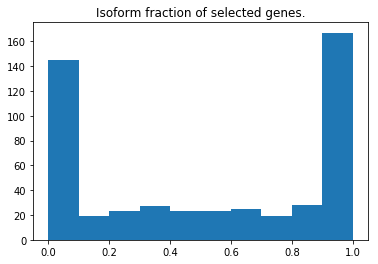

In [96]:
plt.hist(catable.isofract)
plt.title('Isoform fraction of selected genes.')

(array([263.,  84.,  60.,  41.,  31.,  12.,   4.,   2.,   0.,   2.]),
 array([ 0.        ,  1.12760632,  2.25521264,  3.38281896,  4.51042528,
         5.6380316 ,  6.76563791,  7.89324423,  9.02085055, 10.14845687,
        11.27606319]),
 <a list of 10 Patch objects>)

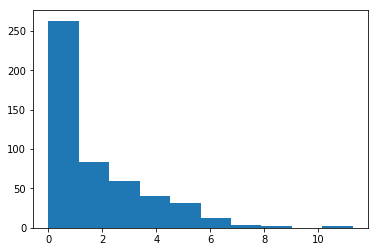

In [97]:
plt.hist(np.log2(catable.FPKM+1))

In [98]:
# Read codebook
cwords = []
with open('/home/rfor10/repos/seqfish_design/MHD4_24bit_472cwords.csv', 'r') as f:
    column_name = f.readline().strip()
    for l in f.readlines():
        cwords.append(''.join(l.strip().split(',')))


In [102]:
len(cwords)

942

In [103]:
i = 0
for idx, row in catable.iterrows():
    catable.set_value(idx, 'barcode', cwords[i])
    i+=1
catable['barcode'] = catable['barcode'].apply(lambda x: str(x))
catable

/home/rfor10/anaconda3/envs/binfo/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  app.launch_new_instance()


,Gene,GeneDescription,Ensembl,gid,Reason,isoformOligos,geneOligos,maxLengthOligos,FPKM,GeneSource,length,max length,Rank (lower is better),TranscriptId,Include for technical reasons,"Made the cut! (<=0 didn't, 1 did, 2 error correct)",Unnamed: 16,best_tid,isofract,barcode
0,CAMK4,calcium/calmodulin dependent protein kinase IV,ENSG00000152495,814.0,Ca Depende Response,151.0,178.0,206.0,0.067661,kegg,12229.0,12229.0,2.0,ENST00000282356.8,1.0,1.0,NaN,ENST00000282356,1.000000,000000000000000001001101
1,BEST1,bestrophin 1 isoform 1,ENSG00000167995,7439.0,Ca Dependent Response,23.0,78.0,167.0,8.186219,meyer,2729.0,5765.0,1.0,ENST00000378043.8,1.0,1.0,NaN,ENST00000449131,0.314773,000000000000000100100110
2,CABIN1,calcineurin binding protein 1,ENSG00000099991,23523.0,Ca Dependent Response,6.0,181.0,211.0,3.617336,meyer,7443.0,7443.0,1.0,ENST00000398319.6,1.0,1.0,NaN,ENST00000398319,0.391162,000000000000000111001000
3,CALM1,"calmodulin 1 (phosphorylase kinase, delta)",ENSG00000198668,801.0,Ca Dependent Response,11.0,27.0,105.0,11.221252,kegg,1415.0,4236.0,1.0,ENST00000553630.1,1.0,2.0,NaN,ENST00000356978,0.255878,000000000000001000001011
4,CALM2,calmodulin 2,ENSG00000143933,805.0,Ca Dependent Response,10.0,18.0,79.0,42.144482,meyer,999.0,4497.0,1.0,ENST00000432899.5,1.0,1.0,NaN,ENST00000272298,0.545800,000000000000001001000110
5,CALM3,"calmodulin 3 (phosphorylase kinase, delta)",ENSG00000160014,808.0,Ca Dependent Response,51.0,67.0,72.0,11.656693,kegg,2533.0,2533.0,1.0,ENST00000486500.1,1.0,2.0,NaN,ENST00000291295,0.280790,000000000000001010011000
6,CALML3,calmodulin like 3,ENSG00000178363,810.0,Ca Dependent Response,59.0,59.0,72.0,1.003533,kegg,2762.0,2762.0,1.0,ENST00000315238.2,1.0,1.0,NaN,ENST00000315238,1.000000,000000000000001100010001
7,CALML4,calmodulin like 4,ENSG00000129007,91860.0,Ca Dependent Response,1.0,4.0,112.0,0.109821,kegg,982.0,4599.0,1.0,ENST00000467889.1,1.0,1.0,NaN,ENST00000540479,0.087409,000000000000010000001110
8,CAMK1,calcium/calmodulin-dependent protein kinase I,ENSG00000134072,8536.0,Ca Dependent Response,4.0,31.0,39.0,1.159784,meyer,1476.0,1484.0,1.0,ENST00000256460.7,0.0,NaN,NaN,ENST00000256460,0.811832,000000000000010000011001
9,CAMK1D,calcium/calmodulin-dependent protein kinase ID...,ENSG00000183049,57118.0,Ca Dependent Response,186.0,186.0,223.0,0.047269,meyer,8142.0,8142.0,2.0,ENST00000619168.4,1.0,1.0,NaN,ENST00000619168,1.000000,000000000000010011010000


In [104]:
def import_readouts(fname):
    readouts = []
    seq = ''
    with open(fname, 'r') as f:
        for line in f.readlines():
            if line[0]=='>':
                rname = line[1:].strip()
                if len(seq)>0:
                    readouts.append((rname, seq))
                seq = ''
                continue
            seq+=line.strip()
    return readouts


In [106]:
!pwd

/home/rfor10/repos/seqfish_design/ca_celltype_v2


In [105]:
table = catable
readout_names, seqs = zip(*import_readouts('/home/rfor10/repos/seqfish_design/24bit_disulfide_readouts.fasta'))
with open('calcium_codebook_final_v2.csv', 'w') as f:
    f.write('version'+','+str(1)+'\n')
    f.write('codebook_name'+','+'mixed_125MHD4_263MHD2'+'\n')
    f.write('bit_names,'+','.join(readout_names)+'\n')
    f.write('name, id, barcode\n')
    for idx, row in table.iterrows():
        transcripts = row['best_tid'].split(',')
        for t in transcripts:
            t = t.strip(' ')
#             print(table.loc[idx].barcode)
            f.write(','.join([row.Gene, t, str(table.loc[idx].barcode)])+'\n')



# Import data from MERFISH Matlab

In [ ]:
# TODO

There were gene duplicates which causes some genes to have more than 
4 barcodes to be assigned to single gene

Rerun the oligo design tool

Parse dataset and balance readouts
Find unique symbols - iterate through
oligos randomly and assign next item in list of readouts

In [7]:
def parse_merfish_oligos(fname, counts_df = None,
                         counts_df_column='FPKM', tid_column='transcript_id'):
    from Bio import SeqIO
    import pandas as pd
    df = pd.DataFrame(columns=['experiemnt', 'pleft', 'ro1', 'ro2', 'ro3', 
                               'pright', 'seq', 'gene', 'tid', 
                              'start', 'length', 'gc', 'tm', 'specicity'])
    readout_dict = {}
    oligos = SeqIO.FastaIO.SimpleFastaParser(open(fname, 'r'))
    rows = []
    fpkms = []
    for header, seq in oligos:
        fields = header.split(' ')
        experiment = str(fields[0])
        primer_left = str(fields[1])
        primer_seqL = seq[:20]
        primer_seqR = seq[-20:]
        readout1 = str(fields[2])
        readout_dict[readout1] = seq[20+1:20+1+20]
        if '__' not in fields[3]:
            readout2 = str(fields[3])
            encoding = str(fields[4])
            readout3 = fields[5]
            ro2_start_idx = 41
            ro3_start_idx = 92
            readout_dict[readout3] = seq[20+20+20+1+30+1:20+1+20+20+30+1+20]
            readout_dict[readout2] = seq[20+1+20:20+1+20+20]
            primer_right = fields[6]
            gene, tid, start, length, gc, tm, specificity, isoSpecificity  = encoding.split('__')
            encoding_region = seq[20+1+20+20:20+20+1+20+30]
        else:
            encoding = fields[3]
#             isoSpecificity = fields[4]
            readout2 = fields[4]
            readout3 = fields[5]
            ro2_start_idx = 72
            ro3_start_idx = 92
            readout_dict[readout2] = seq[20+2+20+30:20+20+30+20+2]
            readout_dict[readout3] = seq[20+2+20+30+20:20+20+30+20+20+2]
            primer_right = fields[6]
            gene, tid, start, length, gc, tm, specificity, isoSpecificity  = encoding.split('__')
        # IMPLEMENT READOUT DICT In If Else
            encoding_region = seq[20+1+20:20+1+20+30]
        
        rows.append([experiment, primer_seqL, readout1, readout2, readout3, 
                       primer_seqR, encoding_region, seq, gene, tid, start,
                     length, gc, tm, specificity, isoSpecificity, header])
    df = pd.DataFrame(rows, columns=['experiment', 'pleft', 'ro1', 'ro2', 'ro3', 
                               'pright', 'encodingRegion', 'seq', 'gene', 'tid', 
                              'start', 'length', 'gc', 'tm', 'specificity', 'isoSpecificity', 'header'])
    df = df.drop_duplicates(subset=['gene', 'encodingRegion'])
    if isinstance(counts_df, pd.DataFrame):
        for tid in df.tid.unique():
            fpkm = counts_df[counts_df[tid_column]==tid][counts_df_column]
            tid_idx = df[df.tid==tid].index
            for i in tid_idx:
                df.set_value(i, counts_df_column, fpkm.values[0])
    df = df.convert_objects(convert_numeric=True)
    df.sort_values(['gene', 'specificity', 'isoSpecificity'], ascending=False, inplace=True)
    df['iso_off_spots'] = (df[counts_df_column] - df['isoSpecificity']*df[counts_df_column])/df['isoSpecificity']
    df['gene_off_spots'] = (df[counts_df_column] - df['specificity']*df[counts_df_column])/df['specificity']
#     df = df.drop_duplicates('tid')
    return df, primer_seqL, primer_seqR, readout_dict

def trim_oligos_to_fit(oligo_df, multi_transcripts_cutoff = 148, min_oligos=48):
    df2 = oligo_df.copy()
    c = Counter(df2.gene)
    high_count = {}
    for g, count in c.items():
        if count < min_oligos:
            print(g, count)
#             c.pop(g)
            if g not in ['SNAI2', 'SNAI1', 'ORAI1', 'P2RY11', 'INPP1', 'ACTA2', 'PICK1']:
                df2.drop(df2[df2.gene==g].index, inplace=True)
#         if count>multi_transcripts_cutoff:
#             high_count[g] = count
#             ixes = list(df2[df2.gene==g].index)
#             ixes = np.random.choice(ixes, size=multi_transcripts_cutoff, replace=False)
#             df2.drop(ixes, inplace=True)
    return df2

# def balance_readouts(df, per_tid=64, fa_out='mergos.fa'):
#     from itertools import repeat
#     tids = df.groupby(group)
#     f = open(fa_out, 'w')
#     new_df = pd.DataFrame()
#     counters = []
#     for name, group in tids:
#         r_used = pd.unique(np.concatenate((group.ro1.unique(),group.ro2.unique(),group.ro3.unique())))
        
def balance_readouts(df, primersL, primersR, readouts, per_tid=64, group='tid',
                     fa_out='python_mergos.fa', sep='__'):
    verbose=False
    from itertools import repeat
    tids = df.groupby(group)
    f = open(fa_out, 'w')
    new_df = pd.DataFrame()
    counters = {}
    for name, group in tids:
        counts = Counter()
        r_used = pd.unique(np.concatenate((group.ro1.unique(),group.ro2.unique(),group.ro3.unique())))
        r_used = np.concatenate(list(repeat(r_used, 1000)))
        oligo_index = group.index.tolist()
        np.random.shuffle(oligo_index)
        oligo_index = oligo_index[:per_tid]
        base_idx = 0
        c = Counter()
        for i, idx in enumerate(oligo_index):
            ro1_seq = ''
            ro2_seq = ''
            ro3_seq = ''
            oligo = ''
            ro1=''
            ro2=''
            ro3=''
#             try:
            ro1_seq = readouts[r_used[base_idx]]
            ro1 = r_used[base_idx]
        
            ro2_seq = readouts[r_used[base_idx+1]]
            ro2 = r_used[base_idx+1]
            
            ro3_seq = readouts[r_used[base_idx+2]]
            ro3 = r_used[base_idx+2]
            
            c.update([ro1, ro2, ro3])
            row = group.loc[idx]
            rand = np.random.randint(0, high=2)
            if (ro1 not in r_used) or (ro2 not in r_used) or (ro3 not in r_used):
                print(row)
            if rand:
                oligo = row.pleft+'A'+ro1_seq+ro2_seq+row.encodingRegion+'A'+ro3_seq+row.pright

#                     row.set_value(idx, 'oligo', row.pleft+row.ro1+row.ro2+'A'+row.encodingRegion+'A'+row.ro3+row.pright)
            else:
                oligo = row.pleft+'A'+ro1_seq+row.encodingRegion+'A'+ro2_seq+ro3_seq+row.pright
            if (len(row.encodingRegion) != 30) or (len(ro1_seq) != 20):

                print(len(row.encodingRegion), len(ro1_seq))
#                     row.set_value(idx, 'oligo', row.pleft+row.ro1+'A'+row.encodingRegion+'A'+row.ro2+row.ro3+row.pright)
            header = ">"+row.gene+sep+row.tid+sep+str(row.start)+sep+ro1+sep+ro2+sep+ro3+sep+row.experiment+'\n'
            f.write(header)
            f.write(oligo+'\n')
            base_idx += 3
#             except Exception as e:
#                 print(e)
#                 continue
        counters[name] = c
        if len(c.keys())>4:
            print(name)
    f.close()
    return new_df, fa_out, counters

In [8]:
import pdb

In [9]:
def parse_merfish_oligos2ro(fname, counts_df = None,
                         counts_df_column='FPKM', tid_column='transcript_id'):
    from Bio import SeqIO
    import pandas as pd
    df = pd.DataFrame(columns=['experiemnt', 'pleft', 'ro1', 'ro2', 'ro3', 
                               'pright', 'seq', 'gene', 'tid', 
                              'start', 'length', 'gc', 'tm', 'specicity'])
    readout_dict = {}
    oligos = SeqIO.FastaIO.SimpleFastaParser(open(fname, 'r'))
    rows = []
    fpkms = []
    for header, seq in oligos:
        fields = header.split(' ')
        experiment = str(fields[0])
        primer_left = str(fields[1])
        primer_seqL = seq[:20]
        primer_seqR = seq[-20:]
        readout1 = str(fields[2])
        readout_dict[readout1] = seq[20+1:20+1+20]
        
        encoding = str(fields[3])
        readout2 = str(fields[4])
        ro2_start_idx = 41
        #readout_dict[readout2] = seq[20+1+20:20+1+20+20]
        primer_right = fields[5]
        splitsies = encoding.split('__')
        gene, tid, start, length, gc, tm, specificity, isoSpecificity = splitsies
        encoding_region = seq[20+1+20:20+20+1+30]

        #isoSpecificity = fields[4]
        #pdb.set_trace()
        rows.append([experiment, primer_seqL, readout1, readout2, 
                       primer_seqR, encoding_region, seq, gene, tid, start,
                     length, gc, tm, specificity, isoSpecificity, header])
    df = pd.DataFrame(rows, columns=['experiment', 'pleft', 'ro1', 'ro2', 
                               'pright', 'encodingRegion', 'seq', 'gene', 'tid', 
                              'start', 'length', 'gc', 'tm', 'specificity', 'isoSpecificity', 'header'])
    df = df.drop_duplicates(subset=['gene', 'encodingRegion'])
    if isinstance(counts_df, pd.DataFrame):
        for tid in df.tid.unique():
            fpkm = counts_df[counts_df[tid_column]==tid][counts_df_column]
            tid_idx = df[df.tid==tid].index
            for i in tid_idx:
                df.at[i, counts_df_column] = fpkm.values[0]
    df = df.convert_objects(convert_numeric=True)
    df.sort_values(['gene', 'specificity', 'isoSpecificity'], ascending=False, inplace=True)
    df['iso_off_spots'] = df.FPKM*(1-df['isoSpecificity'])/df['isoSpecificity']
    df['gene_off_spots'] = df.FPKM*(1-df['specificity'])/df['specificity']
#     df = df.drop_duplicates('tid')
    return df, primer_seqL, primer_seqR, readout_dict

In [112]:
%pdb

Automatic pdb calling has been turned ON


In [10]:
df, pl, pr, ros = parse_merfish_oligos('/bigstore/GeneralStorage/Rob/merfish/MERFISH_analysis-master/human/cacelltypes_v2_newshit3/cacelltypes_v2_oligos.fasta', 
                            counts_df=stringtie_counts)

# df = df[~(df.iso_off_spots==float('inf'))]
# df = df[~(df.gene_off_spots==float('inf'))]

# df = df[df.iso_off_spots<2]



/home/rfor10/anaconda3/envs/binfo/lib/python2.7/site-packages/ipykernel/__main__.py:57: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/rfor10/anaconda3/envs/binfo/lib/python2.7/site-packages/ipykernel/__main__.py:58: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In [ ]:
include = ['VIM', 'TYMS', 'TRPC4AP', 'TP63', 'STIM2', 'STAT5A', 'SRC', 'SLC25A4', 
          'SLC25A25', 'RRM2', 'RHOT1', 'RCN2', 'RCAN3', 'RACGAP1', 'PTK2B', 'PSENEN', 
          'PSEN2', 'PSEN1', 'PRKD3', ]

not_sure = ['STIM1', ]

In [271]:
for g in df[df.iso_off_spots>2].gene.unique():
    print(stringtie_counts[stringtie_counts.ref_gene_name==g].iloc[:3][['transcript_id', 'ref_gene_name', 'FPKM']])
    subdf = df[df.gene==g]
    print(subdf.tid.unique()[0], subdf.gene.unique()[0], subdf.iso_off_spots.max())
    print(subdf.isoSpecificity.unique())

          transcript_id ref_gene_name       FPKM
623820  ENST00000544301           VIM  97.228714
623831  ENST00000224237           VIM  46.911446
623870  ENST00000485947           VIM  31.635349
('ENST00000544301', 'VIM', 351353.0297353042)
[1.0000e+00 2.7665e-04]
          transcript_id ref_gene_name       FPKM
644067  ENST00000332211         VDAC2  47.690155
644078  ENST00000543351         VDAC2  36.316422
644129  ENST00000344036         VDAC2  27.945660
('ENST00000332211', 'VDAC2', 26.09706340574328)
[1.      0.64632 0.69685 0.94947]
          transcript_id ref_gene_name        FPKM
382845  ENST00000395047         VDAC1  182.875519
382855  ENST00000395044         VDAC1   56.549625
382865  ENST00000265333         VDAC1   25.504847
('ENST00000265333', 'VDAC1', 96814.86041859594)
[1.0000e+00 2.6337e-04 2.8595e-01]
           transcript_id ref_gene_name       FPKM
1082645  ENST00000323274          TYMS  33.444309
1082653  ENST00000323224          TYMS  11.379369
1082660  ENST0000058192

          transcript_id ref_gene_name       FPKM
130041  ENST00000358506        PPP1CB  23.259890
130061  ENST00000395366        PPP1CB   7.810980
130051  ENST00000296122        PPP1CB   5.630058
('ENST00000358506', 'PPP1CB', 11202.0139867434)
[0.0063655 0.0020721]
          transcript_id ref_gene_name       FPKM
711321  ENST00000358239        PPP1CA  80.561516
711297  ENST00000376745        PPP1CA  67.057358
711305  ENST00000532446        PPP1CA   5.744546
('ENST00000376745', 'PPP1CA', 24.54354629746195)
[0.73206]
           transcript_id ref_gene_name      FPKM
1060071  ENST00000392995         PPM1D  2.721668
1060079  ENST00000305921         PPM1D  0.985226
1060086  ENST00000629650         PPM1D  0.028379
('ENST00000305921', 'PPM1D', 5.621708012875537)
[1.      0.88508 0.45301 0.31047 0.19555 0.14912]
          transcript_id ref_gene_name      FPKM
135356  ENST00000378551         PPM1B  5.461153
135363  ENST00000282412         PPM1B  1.156703
135391  ENST00000345249         PPM1B  0.

('ENST00000460393', 'MME', 5.168860095336253)
[1.      0.68223 0.62535 0.47283 0.4301  0.3881 ]
          transcript_id ref_gene_name      FPKM
638817  ENST00000361114         MICU1  5.211482
638830  ENST00000398761         MICU1  3.466142
638843  ENST00000476605         MICU1  2.122695
('ENST00000398761', 'MICU1', 452.03579636651557)
[1.        0.92911   0.71646   0.22026   0.0076095]
          transcript_id ref_gene_name      FPKM
933191  ENST00000357742         MCTP2  3.399152
933266  ENST00000561608         MCTP2  0.596634
933235  ENST00000543482         MCTP2  0.156471
('ENST00000357742', 'MCTP2', 4.035075850316033)
[1.      0.88369 0.76738 0.496   0.45723]
          transcript_id ref_gene_name       FPKM
269817  ENST00000265056          MCM2  21.409319
269834  ENST00000474964          MCM2   6.934328
269851  ENST00000477668          MCM2   2.409703
('ENST00000265056', 'MCM2', 9.619129238380268)
[1.      0.98607 0.97214 0.94428 0.83285 0.80499 0.68999 0.88856]
          transcript

('ENST00000393599', 'CDKN2D', 13.248208550490663)
[1.      0.12636]
         transcript_id ref_gene_name      FPKM
40703  ENST00000396148        CDKN2C  7.192264
40698  ENST00000262662        CDKN2C  1.736120
40707  ENST00000371761        CDKN2C  0.820172
('ENST00000262662', 'CDKN2C', 176.84948921668465)
[1.        0.71706   0.0097215]
          transcript_id ref_gene_name       FPKM
426314  ENST00000405375        CDKN1A  63.608627
426318  ENST00000244741        CDKN1A  14.540674
426322  ENST00000615513        CDKN1A   3.882370
('ENST00000405375', 'CDKN1A', 56088.074812265535)
[0.0011328 0.92865  ]
          transcript_id ref_gene_name       FPKM
635207  ENST00000395284          CDK1  34.105686
635216  ENST00000614696          CDK1  12.350564
635225  ENST00000448257          CDK1  12.312920
('ENST00000448257', 'CDK1', 9910.25940653719)
[1.        0.42928   0.2866    0.0012409]
          transcript_id ref_gene_name       FPKM
985176  ENST00000567674          CDH3  33.535461
985126  ENST

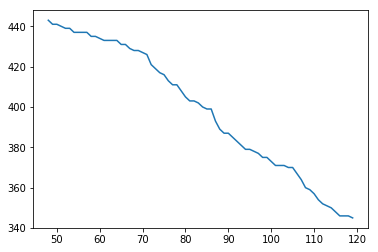

In [11]:
genes, counts = zip(*Counter(df.gene).items())
counts = np.array(counts)
genes = np.array(genes)
cutoff_counts = []
for i in range(48, 120):
    cutoff_counts.append((i, sum(counts>i)))
x,y = zip(*cutoff_counts)
plt.plot(x, y)

                         

In [12]:
df = df[df.gene.isin(genes[counts>=76])]
gene_sets = []
for gene, gdf in df.groupby('gene'):
#     ax1 = plt.subplot(1,2,1)
#     ax2 = plt.subplot(1,2,2)
#     ax1.hist(gdf.specificity)
#     #plt.xlim([0,1])
#     ax2.hist(gdf.isoSpecificity)
#     #plt.xlim([0,1])
#     plt.show()
    probes = gdf.sort_values(['specificity', 'isoSpecificity']).iloc[:120]
    gene_sets.append(probes)
    break
    #print(Counter(np.concatenate((probes.ro1.values, probes.ro2.values))).most_common()[-1])
    

In [13]:
manual_pass = ['ADRA1D', 'ARRB1', 'ATP2B1', 'ATXN1', 'CAMK2B', 'CAMK2D', 'CAMK4', 'CAPN14', 'CAPN5', 'CAPN8', 
              'CAPS2', 'CBY1', 'CBY1', 'CD44', 'CDH2', 'DCLK1', 'DCLK2', 'DGKI', 'DYSF', 'ERBB2', 'GATA3', 'HRH1', 
              'INPP4A', 'INPP5E', 'INPP5J', 'LTB4R2',  'MCTP2', 'MME', 'NPC1L1', 'P2RX4', 'P2RX7', 
              'PHKA2', 'PLEKHH3', 'PPEF1', 'PPM1E', 'PPM1M', 'PRKCH', 'PTGFR', 'RCAN3', 'RYR1', 'SLC24A4', 'SLC8A2', 
              'TP63', 'TRPC1', 'ALDH1A3', 'ATP2B4', 'BDKRB2', 'CABIN1', 'CAMK2G', 'CCNA2', 'CCNE1', 
              'DGKE', 'GNAS', 'HPCAL1', 'HTR7', 'ITPK1', 'ITPR1', 'KIF20A', 'MCM2', 'MSH2', 'PHKB', 
              'PI4KB', 'PKN1', 'PPM1D', 'PPP3CA', 'RACGAP1', 'SRC', 'STAT5A', 'TRPC4AP']

('ALDH1A3', 4.996709767910007)


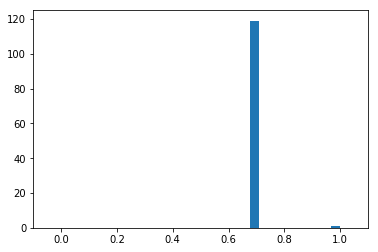

('ATP2B1', 11.137096509259258)


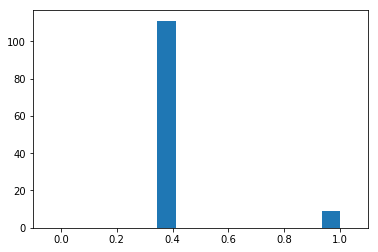

('ATP2B4', 143.3128657670173)


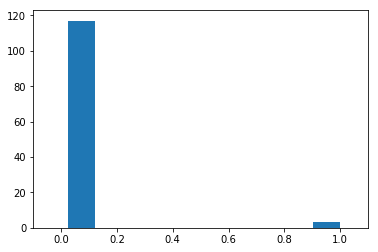

('ATXN1', 3.703573134991119)


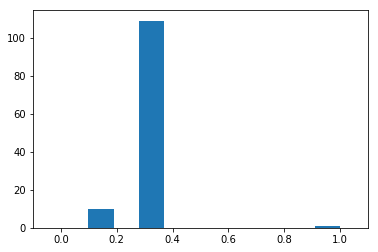

('BDKRB2', 21.084382417487316)


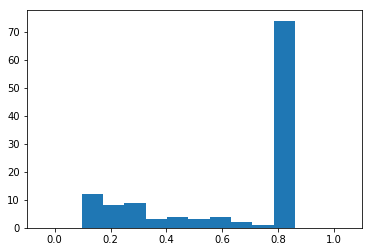

('CABIN1', 7.290739508111694)


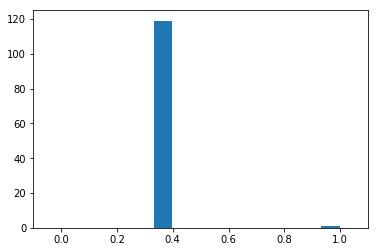

('CAMK2G', 2.3959974725575655)


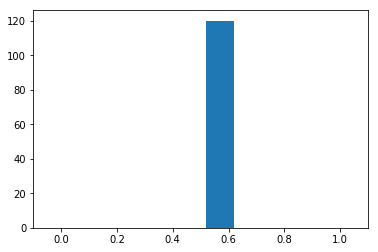

('CCNE1', 7.0536096934668695)


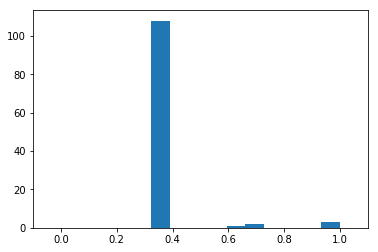

('CCNF', 1.801658514421539)


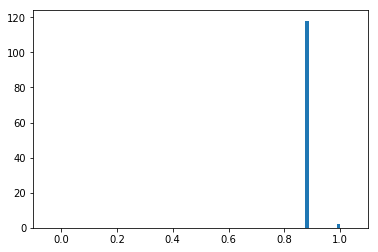

('CD44', 63.521052741702746)


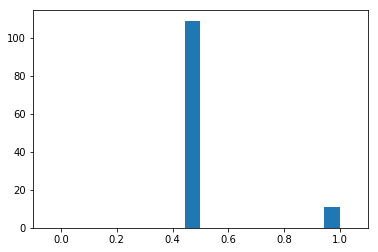

('CENPF', 1.157985322309678)


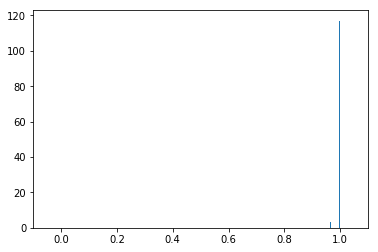

('GATA3', 1.7201877269106778)


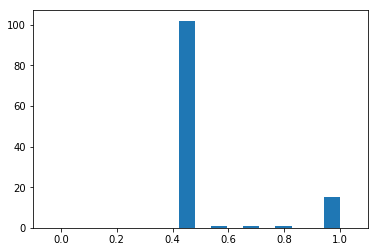

('GNAS', 23.002679153878834)


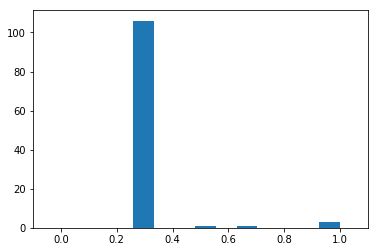

('HPCAL1', 101.17857490289275)


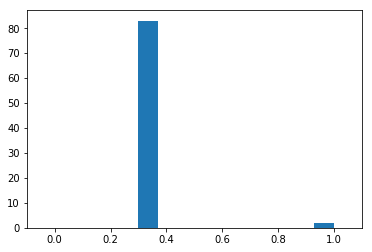

('HTR7', 3.457344590648072)


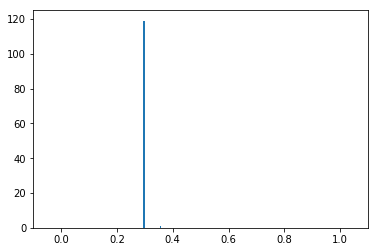

('INPP4A', 5.03175771383975)


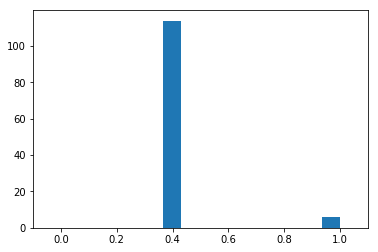

('INPP5E', 2.661374746938414)


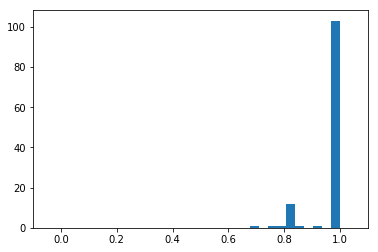

('ITPK1', 27.62648905602313)


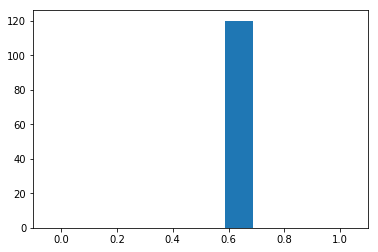

('ITPR1', 4.727069890120356)


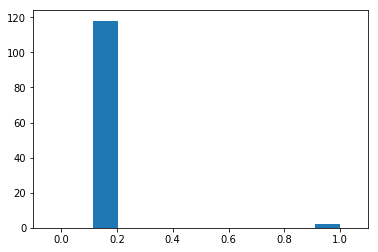

('KIF20A', 2.990634766513205)


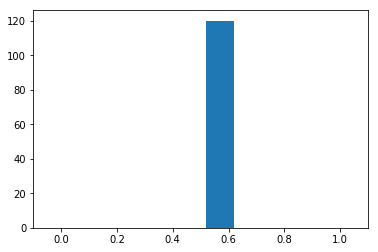

('LETM1', 5.491530864662848)


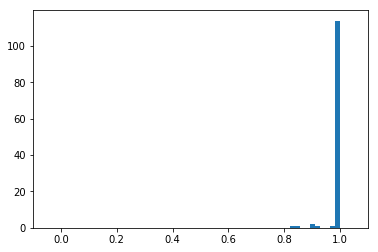

('MCM2', 9.619129238380268)


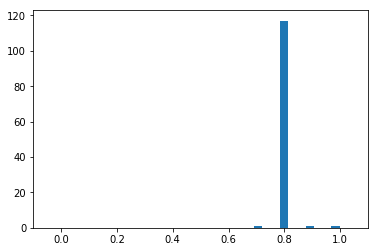

('MCTP2', 4.035075850316033)


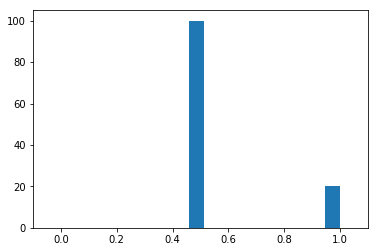

('MME', 5.168860095336253)


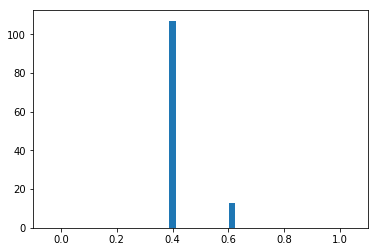

('MSH2', 79.57078189079473)


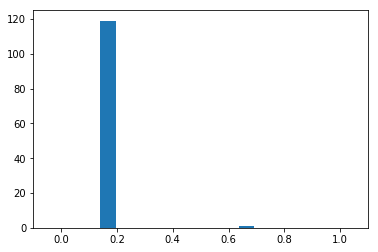

('MYOF', 9.648173464944556)


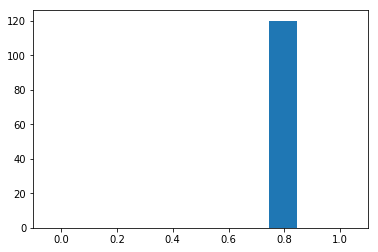

('OCRL', 1.3024825319193454)


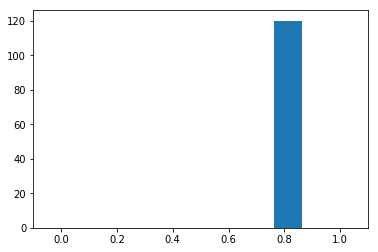

('PHKA2', 1.1454848962628397)


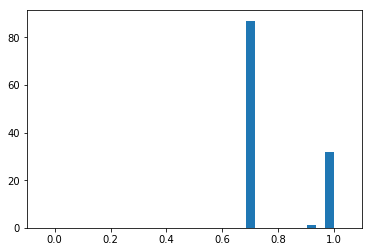

('PHKB', 5.290431973518285)


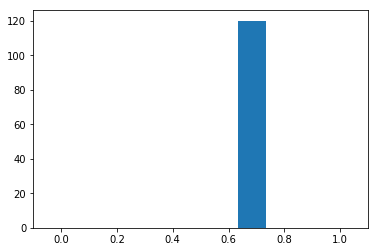

('PI4KB', 13.355818109993967)


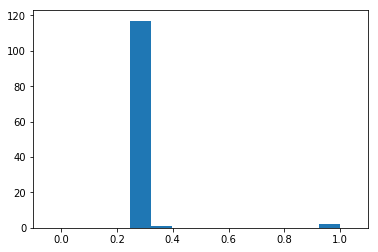

('PIP4K2A', 1.0427581638705463)


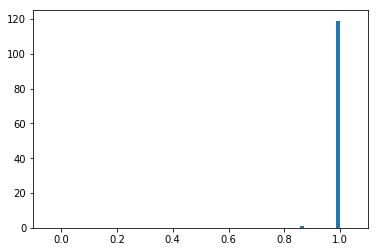

('PKN1', 8.71278639136914)


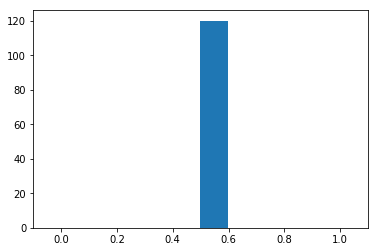

('PKN2', 4.206491109675575)


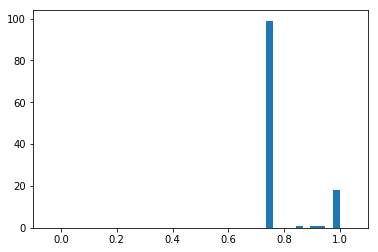

('PLEKHH3', 1.4866579412900978)


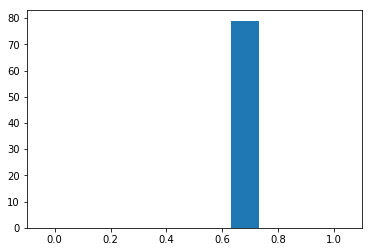

('PPM1D', 5.621708012875537)


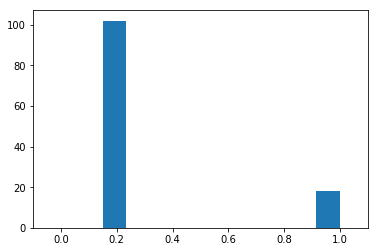

('PPP1CA', 24.54354629746195)


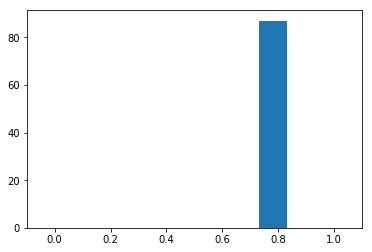

('PPP3CA', 8.230934681057798)


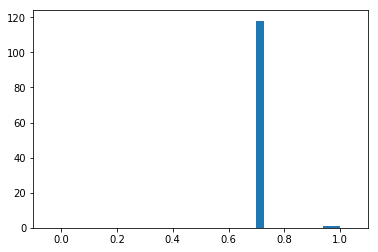

('RACGAP1', 35.4737372309649)


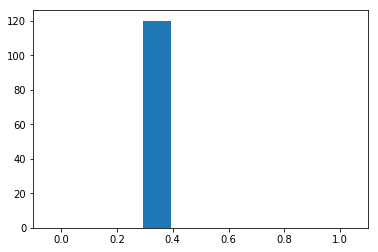

('RCAN3', 2.460705983187191)


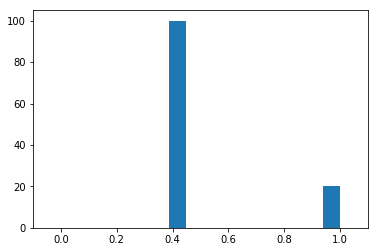

('SNAI2', 1.6863517103049945)


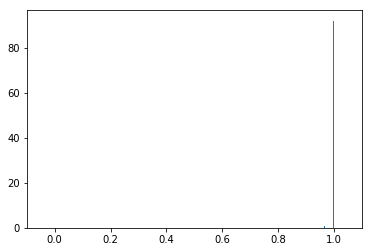

('SRC', 66.97355537763526)


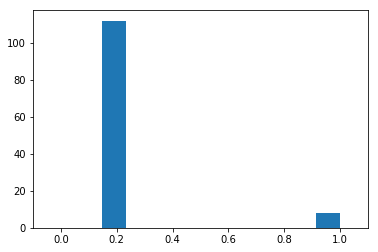

('STAT5A', 6.904571567535189)


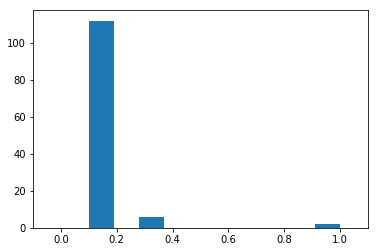

('TP63', 2.1400783716543463)


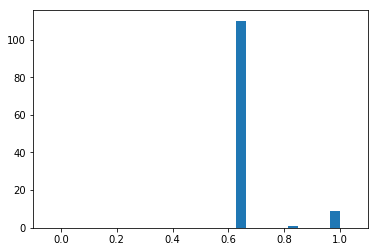

('TRPC4AP', 56.79592909925746)


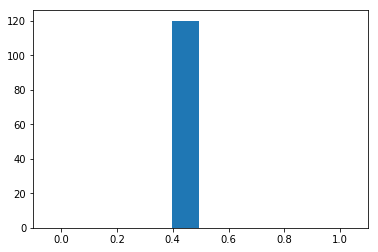

39201

In [14]:
df = df[df.gene.isin(genes[counts>=76])]
gene_sets = []
uncertain_sets = []
noligos = 0
for gene, gdf in df.groupby('gene'):
#     ax1 = plt.subplot(1,2,1)
#     ax2 = plt.subplot(1,2,2)
#     ax1.hist(gdf.specificity)
#     #plt.xlim([0,1])
#     ax2.hist(gdf.isoSpecificity)
#     #plt.xlim([0,1])
#     plt.show()
    probes = gdf.sort_values(['specificity', 'isoSpecificity']).iloc[:120]
    min_iso_spec = probes['isoSpecificity'].min()
    if min_iso_spec<0.7 and not gene in manual_pass:
        #print(gene)
        uncertain_sets.append((gene, probes))
    #print(gdf['isoSpecificity'].min())
    else:
        gene_sets.append(probes)
        noligos+= probes.shape[0]
        iso_off = probes.iso_off_spots.max()
        if iso_off>1:
            print(gene, iso_off)
            plt.hist(probes.isoSpecificity)
            plt.xlim(-0.1, 1.1)
            plt.show()
        #print()
    #print(Counter(np.concatenate((probes.ro1.values, probes.ro2.values))).most_common()[-1])
noligos

('ALDH1A3', 10.406218)


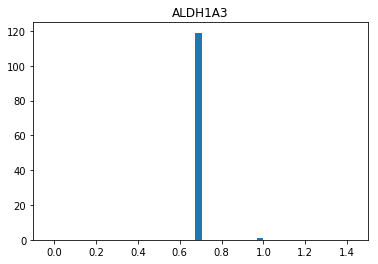

('APH1B', 0.94491)


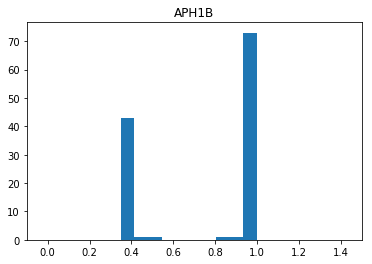

('ARRB2', 6.024266)


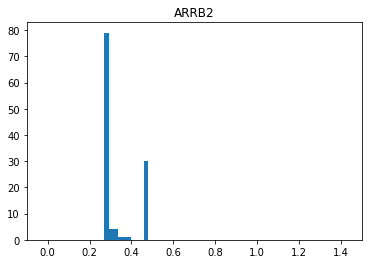

('ATP2B4', 3.374694)


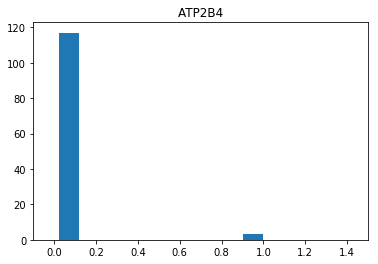

('AURKA', 22.525574)


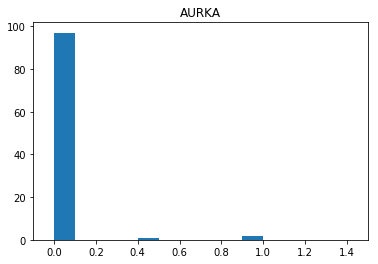

('BDKRB2', 2.248522)


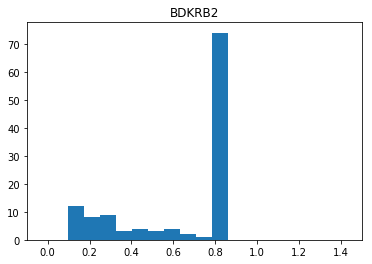

('BIRC5', 1.677905)


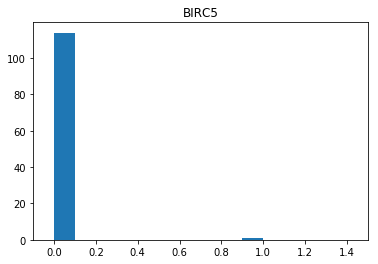

('BRCA1', 3.781972)


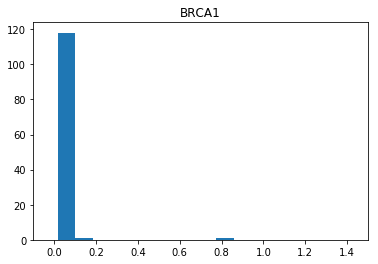

('BUB1', 10.209517)


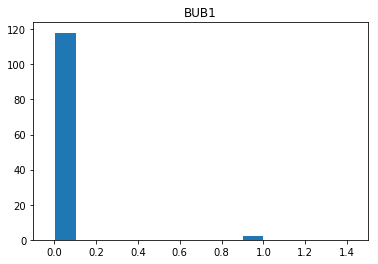

('CABIN1', 3.617336)


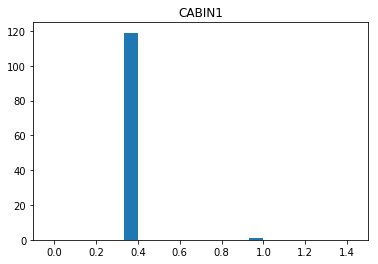

('CALM1', 11.221252)


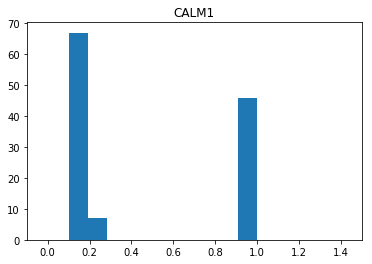

('CAMK1D', 0.047269)


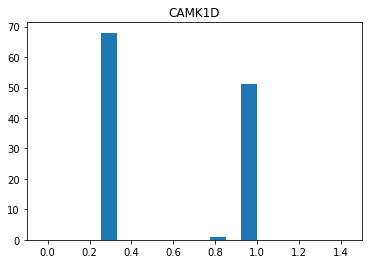

('CAMK2G', 2.580527)


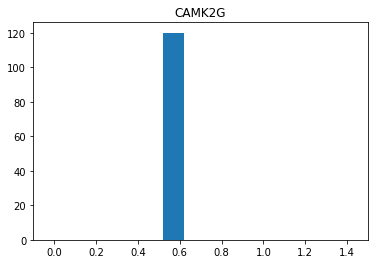

('CAMKK2', 7.381094)


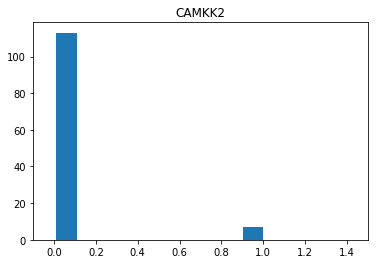

('CAPN10', 0.370227)


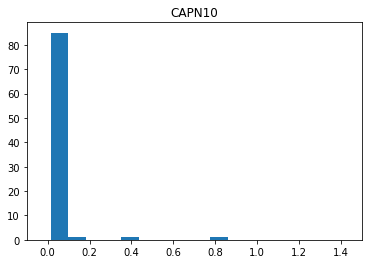

('CAPNS1', 17.48823)


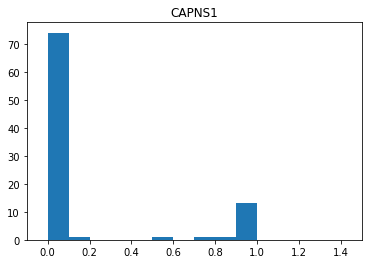

('CASK', 2.480205)


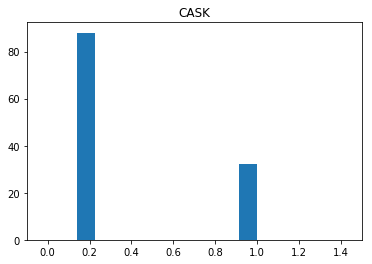

('CCNA2', 0.001205)


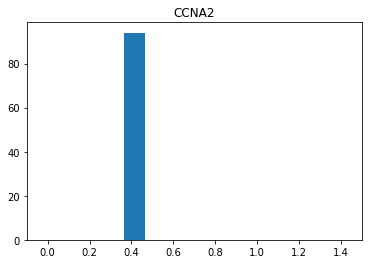

('CCNB1', 95.831779)


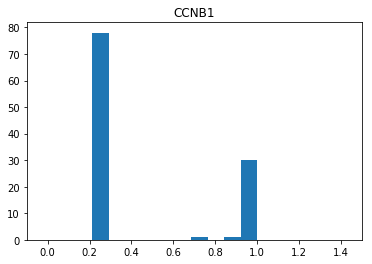

('CCNB2', 0.74671)


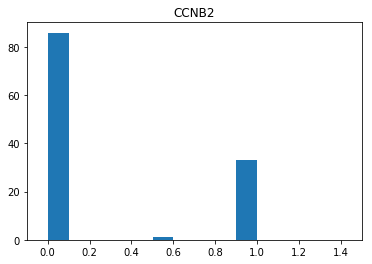

('CCNE1', 3.357776)


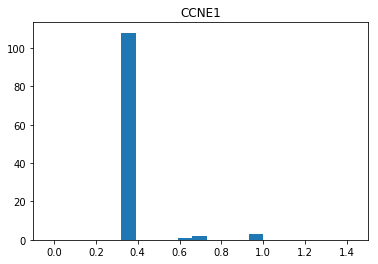

('CCNG2', 3.40623)


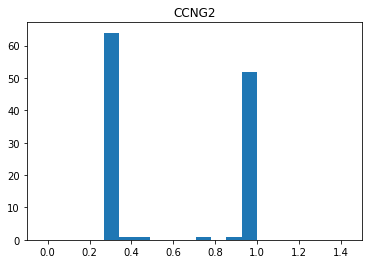

('CDC20', 30.777426)


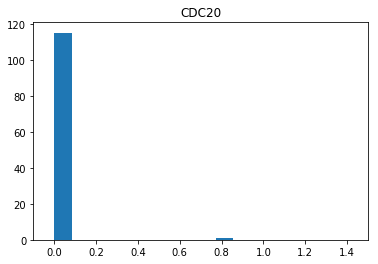

('CDC25B', 0.992032)


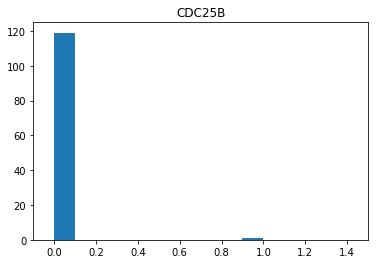

('CDC45', 3.183863)


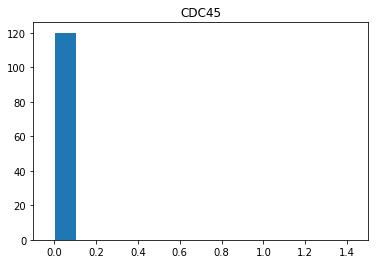

('CDH3', 17.696449)


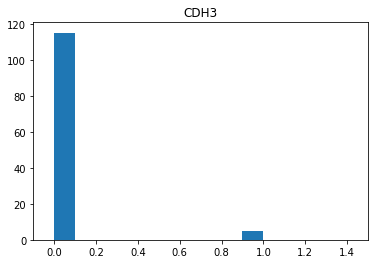

('CDKN1A', 63.608627)


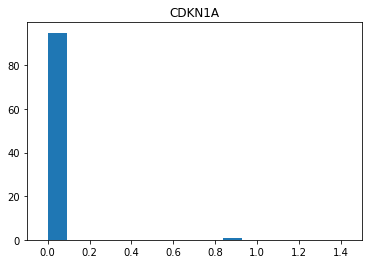

('CDKN2C', 1.73612)


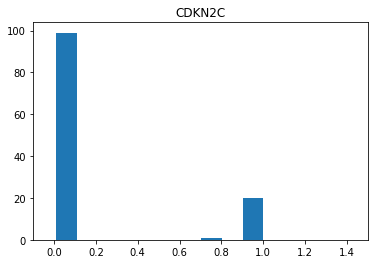

('DGKD', 5.221056)


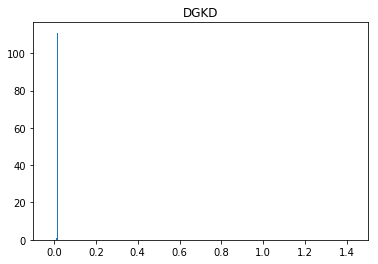

('DGKE', 0.884683)


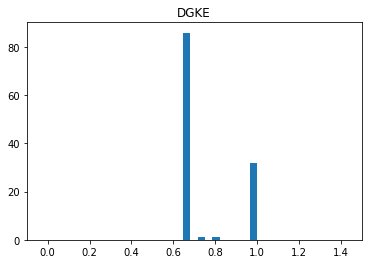

('DGKZ', 1.300699)


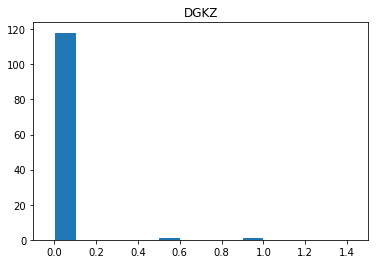

('DUOX1', 1.503723)


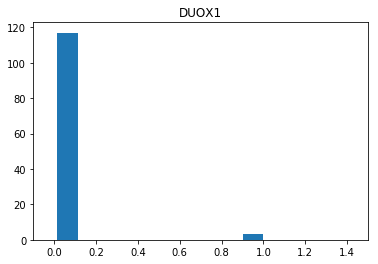

('ENKUR', 0.030089)


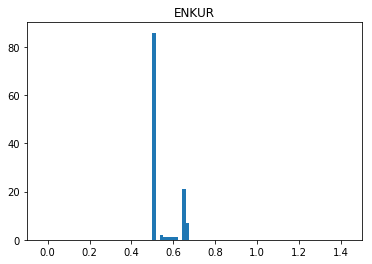

('GNAS', 8.038816)


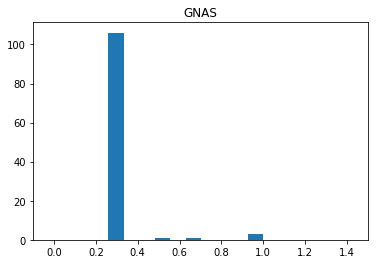

('GNB1', 43.684887)


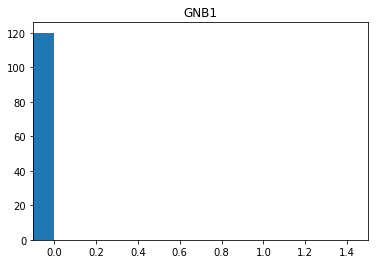

('GNG4', 0.338137)


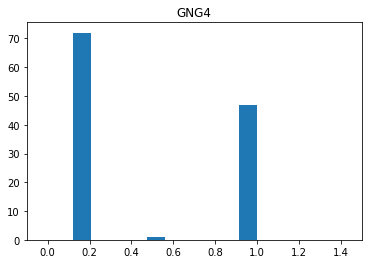

('GRK6', 5.305884)


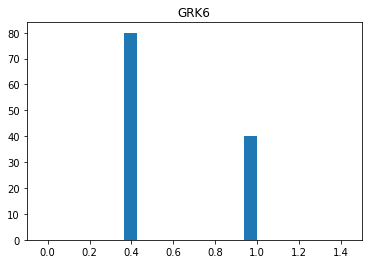

('HPCAL1', 43.018234)


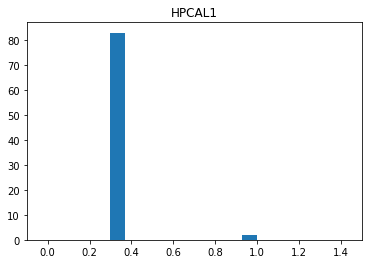

('HTR7', 1.429776)


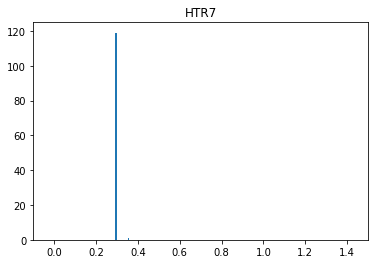

('INPP1', 1.753074)


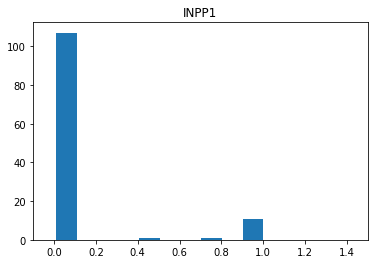

('INPP4B', 3.418198)


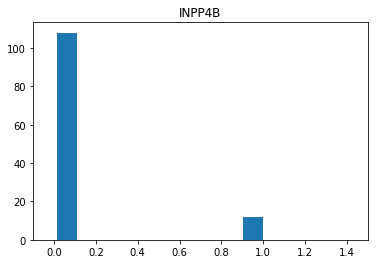

('ITGA6', 91.278839)


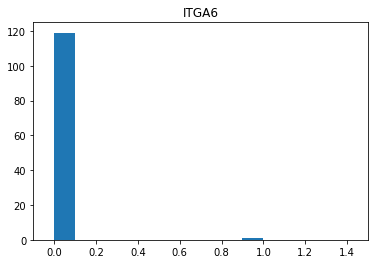

('ITPK1', 39.452518)


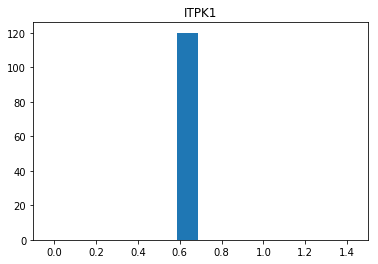

('ITPR1', 0.617211)


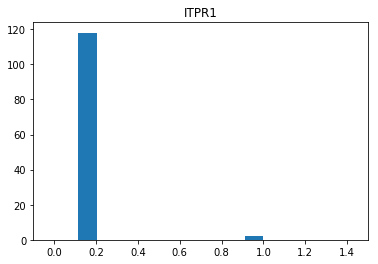

('ITSN2', 2.898441)


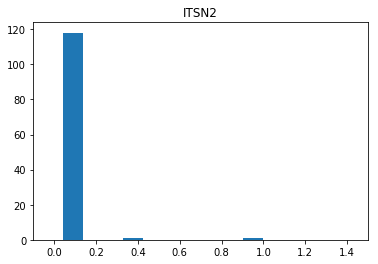

('KIF20A', 3.228582)


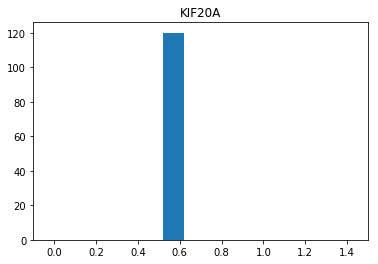

('LETMD1', 0.273165)


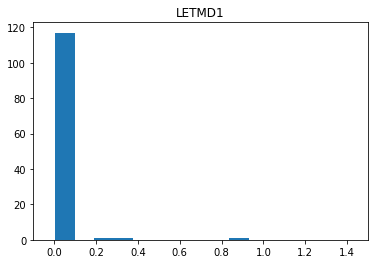

('MCM2', 21.409319)


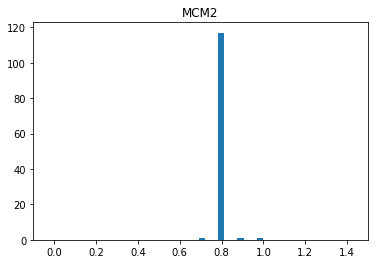

('MCU', 0.304152)


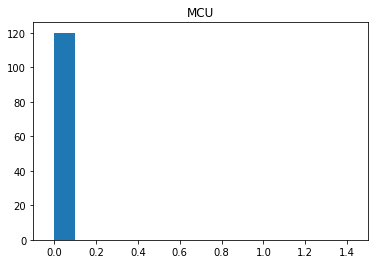

('MICU1', 3.466142)


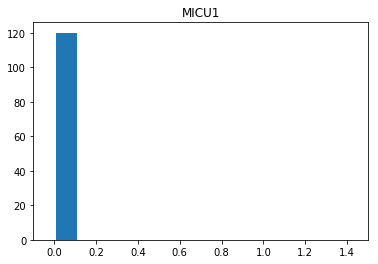

('MSH2', 12.944777)


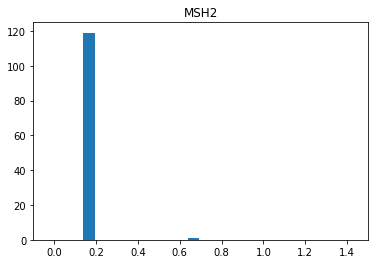

('MUC1', 7.207439)


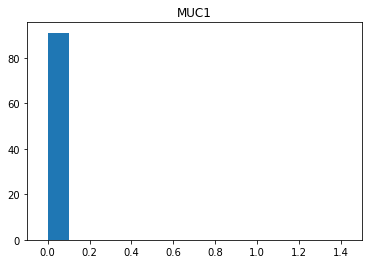

('NASP', 5.458861)


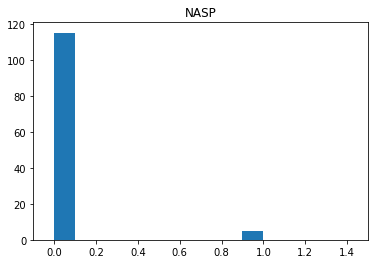

('NCS1', 13.108152)


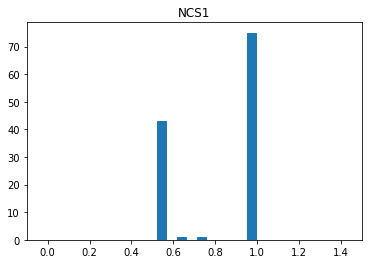

('NOS3', 0.019856)


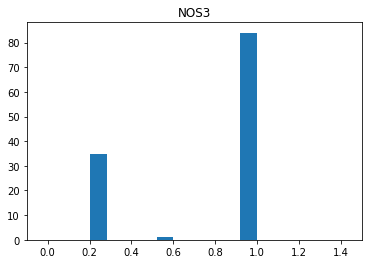

('NUCB2', 1.800104)


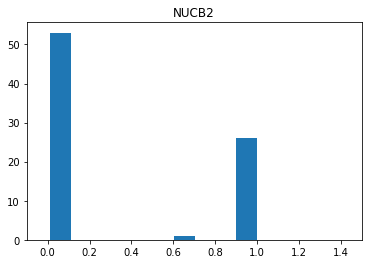

('OCLN', 0.671618)


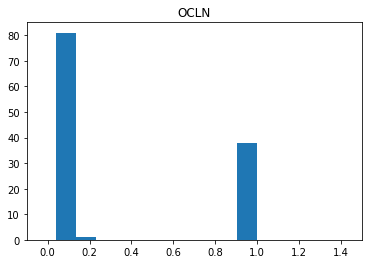

('OVGP1', 0.50631)


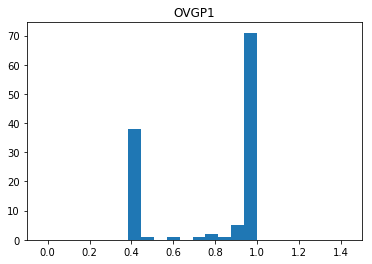

('P2RY2', 2.270317)


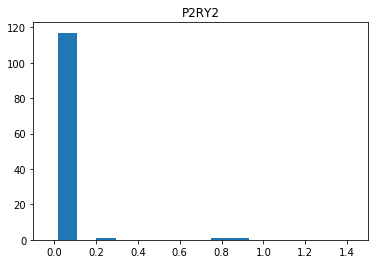

('PDPN', 1.45189)


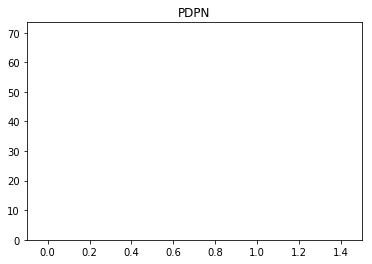

('PHKA1', 4.47383)


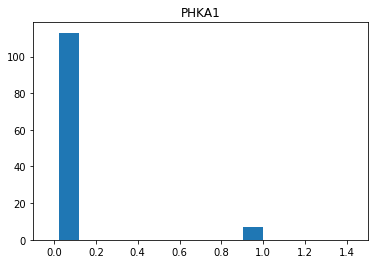

('PHKB', 9.180115)


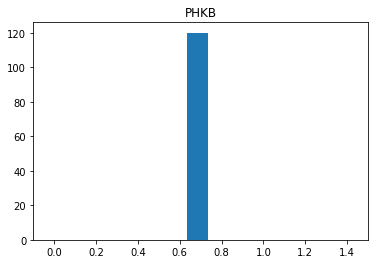

('PI4KB', 4.419943)


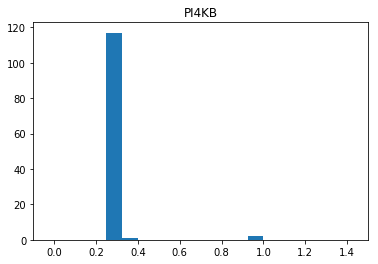

('PICK1', 0.606988)


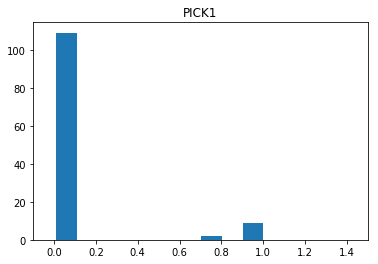

('PIP5K1A', 4.126128)


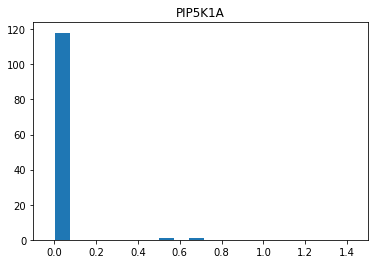

('PKN1', 8.594749)


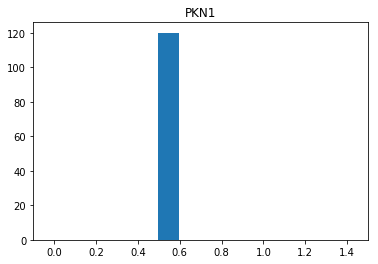

('PLCB2', 0.0)


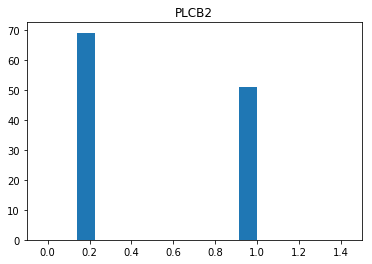

('PLCB3', 20.105455)


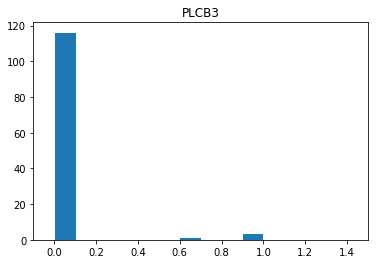

('PLCG1', 4.123507)


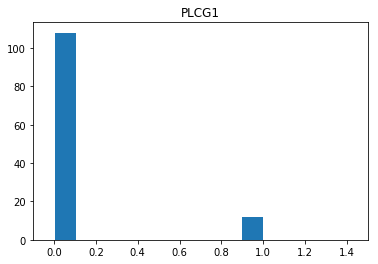

('PLCG2', 0.273255)


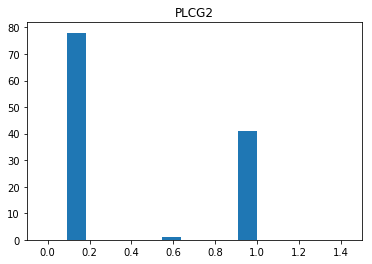

('PLCH2', 3.800031)


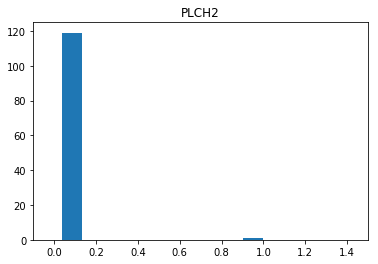

('PMPCA', 1.188029)


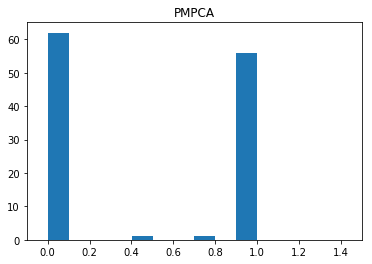

('PPM1A', 2.16482)


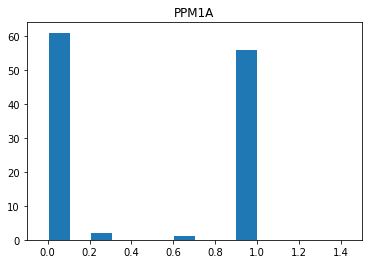

('PPM1B', 5.461153)


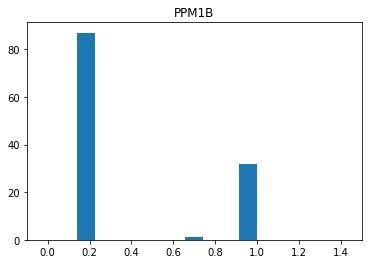

('PPM1D', 0.985226)


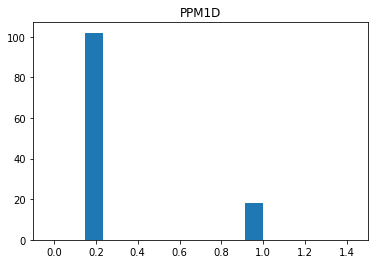

('PPP1CB', 23.25989)


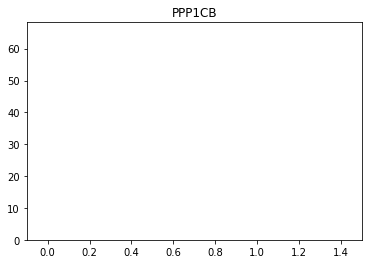

('PPP3CA', 19.097113)


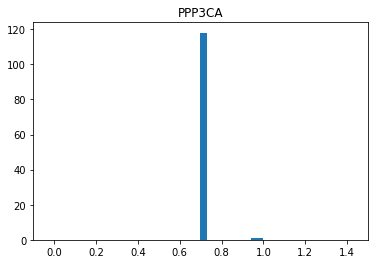

('PPP3CB', 1.633241)


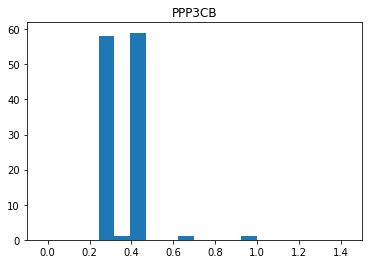

('PRKACB', 2.316167)


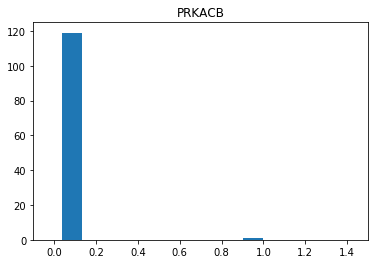

('PRKCD', 0.90395)


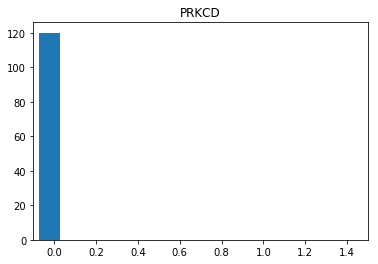

('PRKD2', 5.503308)


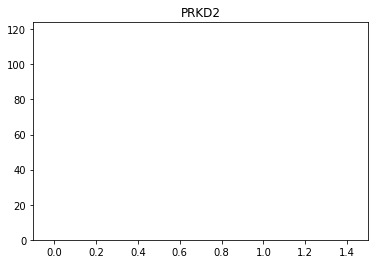

('PRKD3', 4.84052)


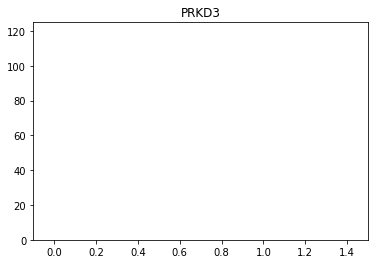

('PSEN1', 9.262045)


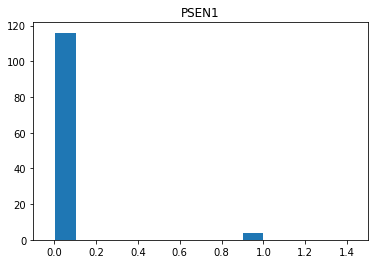

('PSEN2', 10.240426)


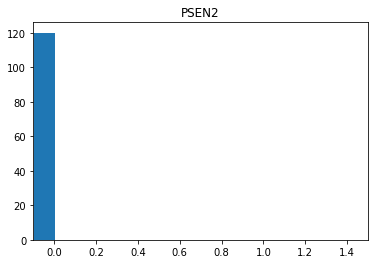

('PSENEN', 13.095641)


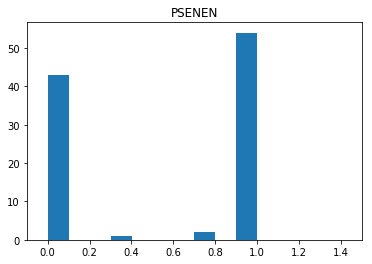

('PTK2B', 10.048185)


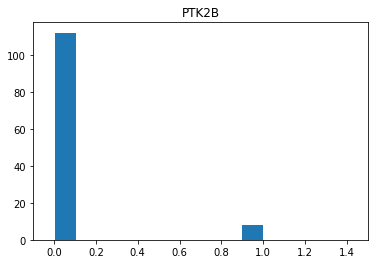

('RACGAP1', 14.832917)


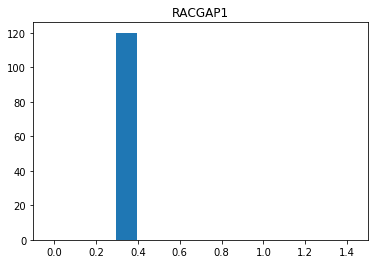

('RCAN1', 0.106991)


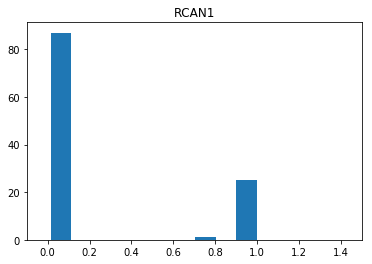

('RCN2', 10.852633)


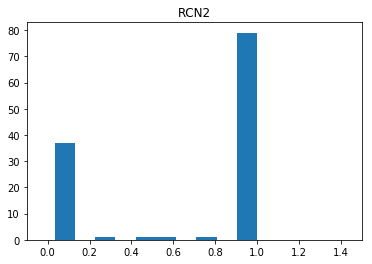

('RGS14', 1.709121)


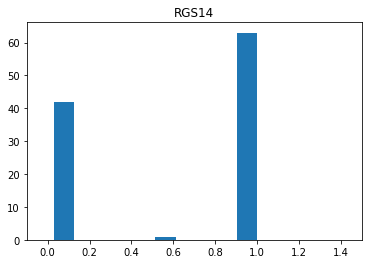

('RHOT1', 2.419127)


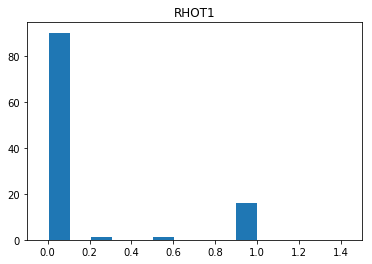

('RRM2', 22.507002)


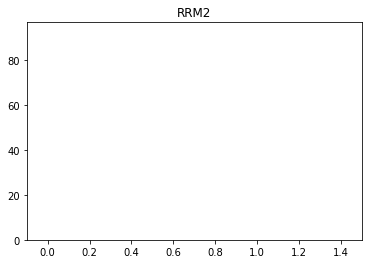

('SLC25A25', 3.29808)


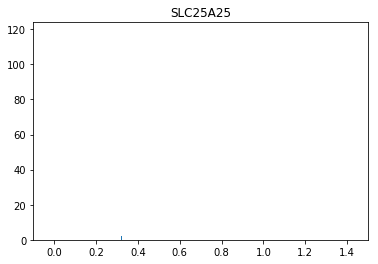

('SLC25A4', 10.87436)


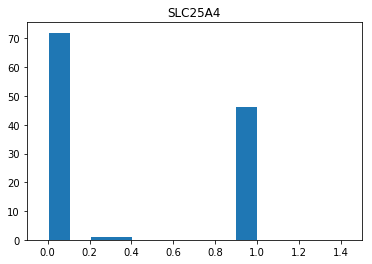

('SLC8A1', 0.014518)


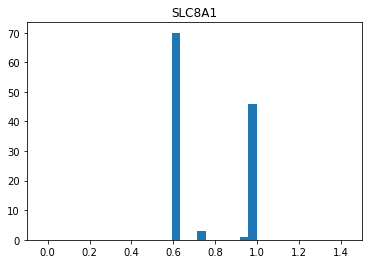

('SRC', 11.50219)


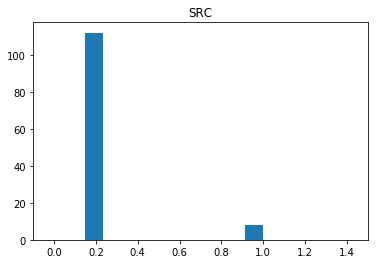

('STAT5A', 0.768624)


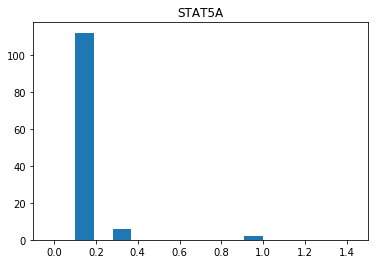

('STIM1', 2.397012)


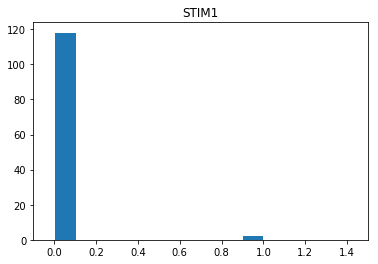

('STIM2', 0.809957)


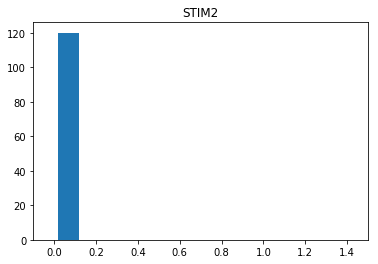

('TRPC4AP', 37.227726)


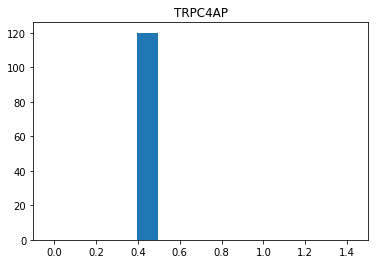

('TYMS', 33.444309)


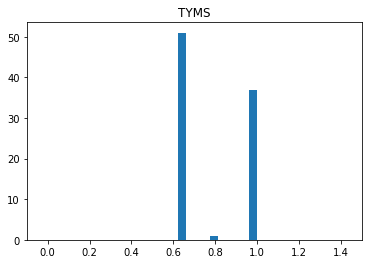

('VDAC1', 25.504847)


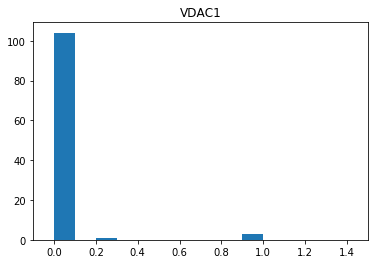

('VIM', 97.228714)


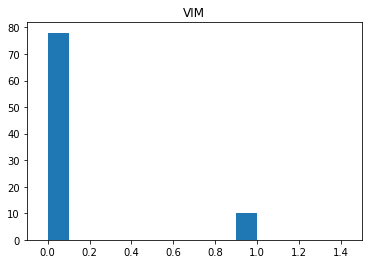

In [357]:
for gene, gdf in uncertain_sets:
    plt.hist(gdf.isoSpecificity)
    plt.title(gene)
    print(gene, gdf.FPKM.unique()[0])
    #print(gdf)
    plt.xlim(-0.1, 1.5)
    plt.show()


,experiment,pleft,ro1,ro2,ro3,pright,encodingRegion,seq,gene,tid,start,length,gc,tm,specificity,isoSpecificity,header,FPKM,iso_off_spots,gene_off_spots


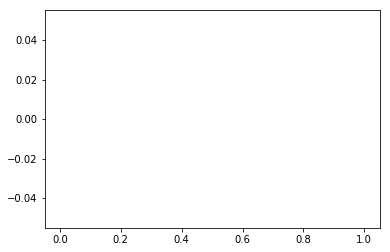

In [370]:
df[df.gene == 'PIP4K2B']
plt.hist(df[df.gene == 'PIP4K2B'].isoSpecificity)
df[df.gene == 'PIP4K2B']

(array([316.,  18.,   0.,   1.,   0.,   1.,   1.,   0.,   0.,   1.]),
 array([  0.       ,  33.9618195,  67.923639 , 101.8854585, 135.847278 ,
        169.8090975, 203.770917 , 237.7327365, 271.694556 , 305.6563755,
        339.618195 ]),
 <a list of 10 Patch objects>)

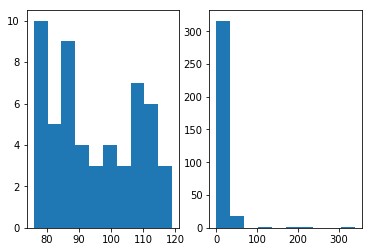

In [15]:
no = [p.shape[0] for p in gene_sets if p.shape[0]<120]
fpkms = [p.FPKM.unique()[0] for p in gene_sets]
plt.subplot(1,2,1)
plt.hist(no)
plt.subplot(1,2,2)
plt.hist(fpkms)

In [16]:
fpkms = [(p.gene.unique()[0], p.FPKM.unique()[0]) for p in gene_sets if p.FPKM.unique()[0]>50]
fpkms

[('CAPN2', 229.635193),
 ('CD44', 50.6269),
 ('GNA15', 56.038643),
 ('PLK1', 54.750069),
 ('PPIF', 65.086143),
 ('PPP1CA', 67.057358),
 ('PPP2CA', 52.357147),
 ('SLC25A5', 339.618195),
 ('SLC25A6', 171.994873),
 ('TOP2A', 66.975395),
 ('VDAC3', 109.237877)]

In [17]:
gene_sets = [d for d in gene_sets if d.FPKM.unique()[0]<200]

In [19]:
df = pd.concat(gene_sets, ignore_index=True)

In [26]:
with open('final_oligos.fa', 'w') as f:
    for idx, line in df.iterrows():
        f.write('>'+line.header+'\n')
        f.write(line.seq+'\n')


(array([ 10.,   4.,   9.,   4.,   3.,   4.,   3.,  10.,   4., 285.]),
 array([ 76. ,  80.4,  84.8,  89.2,  93.6,  98. , 102.4, 106.8, 111.2,
        115.6, 120. ]),
 <a list of 10 Patch objects>)

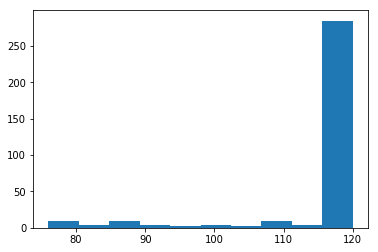

In [28]:
plt.hist([len(i) for i in gene_sets])

(array([249.,  39.,  14.,   9.,   9.,   6.,   5.,   3.,   2.,   4.,   0.,
          0.,   0.,   1.,   2.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([  0.       ,   6.7923639,  13.5847278,  20.3770917,  27.1694556,
         33.9618195,  40.7541834,  47.5465473,  54.3389112,  61.1312751,
         67.923639 ,  74.7160029,  81.5083668,  88.3007307,  95.0930946,
        101.8854585, 108.6778224, 115.4701863, 122.2625502, 129.0549141,
        135.847278 , 142.6396419, 149.4320058, 156.2243697, 163.0167336,
        169.8090975, 176.6014614, 183.3938253, 190.1861892, 196.9785531,
        203.770917 , 210.5632809, 217.3556448, 224.1480087, 230.9403726,
        237.7327365, 244.5251004, 251.3174643, 258.1098282, 264.9021921,
        271.694556 , 278.4869199, 285.2792838, 292.0716477, 298.8640116,
 

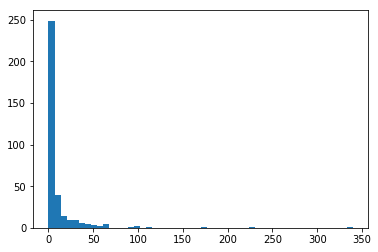

In [366]:
plt.hist(df.FPKM.unique(), bins=50)

In [367]:
catable[~catable.Gene.isin(df.gene.unique())]

,Gene,GeneDescription,Ensembl,gid,Reason,isoformOligos,geneOligos,maxLengthOligos,FPKM,GeneSource,length,max length,Rank (lower is better),TranscriptId,Include for technical reasons,"Made the cut! (<=0 didn't, 1 did, 2 error correct)",Unnamed: 16,best_tid,isofract
4,CALM2,calmodulin 2,ENSG00000143933,805.0,Ca Dependent Response,10.0,18.0,79.0,42.144482,meyer,999.0,4497.0,1.0,ENST00000432899.5,1.0,1.00,NaN,ENST00000272298,0.545800
14,CAMK2N2,CaM-KII inhibitory protein,ENSG00000163888,94032.0,Ca Dependent Response,19.0,19.0,24.0,1.194619,meyer,1360.0,1360.0,1.0,ENST00000296238.3,0.0,NaN,NaN,ENST00000296238,1.000000
74,HOMER3,"Homer, neuronal immediate early gene, 3 isoform 2",ENSG00000051128,9454.0,Ca/ER,10.0,27.0,47.0,2.363323,meyer,1547.0,1970.0,2.0,ENST00000392351.7,0.0,NaN,NaN,ENST00000542541,0.061893
75,ORAI1,ORAI calcium release-activated calcium modulat...,ENSG00000276045,84876.0,Ca/ER,37.0,37.0,50.0,11.301392,kegg,2136.0,2136.0,1.0,ENST00000617316.1,0.0,0.75,NaN,ENST00000617316,1.000000
86,MICU2,"EF-hand domain family, member A1",ENSG00000165487,221154.0,Ca/Mito,21.0,21.0,23.0,25.158855,meyer,1908.0,1908.0,1.0,ENST00000382374.8,0.0,NaN,NaN,ENST00000382374,1.000000
92,VDAC2,voltage dependent anion channel 2,ENSG00000165637,7417.0,Ca/Mito,0.0,25.0,36.0,47.690155,kegg,1547.0,1547.0,1.0,ENST00000332211.10,0.0,NaN,NaN,ENST00000332211,0.407947
104,CDK1,cyclin dependent kinase 1,ENSG00000170312,983.0,cell cycle,0.0,0.0,0.0,12.312920,G2,1905.0,1940.0,1.0,ENST00000395284.7,0.0,NaN,NaN,ENST00000448257,0.202443
113,CDKN2D,cyclin dependent kinase inhibitor 2D,ENSG00000129355,1032.0,cell cycle,0.0,0.0,0.0,1.916171,G2/M,1083.0,1420.0,1.0,ENST00000335766.2,0.0,NaN,NaN,ENST00000393599,0.316557
114,CDKN3,cyclin dependent kinase inhibitor 3,ENSG00000100526,1033.0,cell cycle,1.0,16.0,25.0,5.724306,M/G1,837.0,1064.0,1.0,ENST00000458126.6,0.0,NaN,NaN,ENST00000556102,0.238065
115,CENPA,centromere protein A,ENSG00000115163,1058.0,cell cycle,4.0,16.0,27.0,3.157257,G2/M,739.0,1447.0,1.0,ENST00000460030.1,0.0,NaN,NaN,ENST00000335756,0.870250


In [138]:
df.gene.unique()

array(['VIM', 'VDAC3', 'VDAC2', 'VDAC1', 'TYMS', 'TRPC7', 'TRPC6',
       'TRPC4AP', 'TRPC4', 'TRPC1', 'TRDN', 'TP63', 'TOP2A', 'TECPR2',
       'TECPR1', 'TBXA2R', 'TACR3', 'TACR2', 'TACR1', 'SYNJ2BP', 'SYNJ2',
       'SYNJ1', 'STIM2', 'STIM1', 'STAT5A', 'SRC', 'SPHK2', 'SPHK1',
       'SPERT', 'SNAI2', 'SNAI1', 'SLC8B1', 'SLC8A3', 'SLC8A2', 'SLC8A1',
       'SLC25A5', 'SLC25A4', 'SLC25A25', 'SLC25A13', 'SLC24A5', 'SLC24A4',
       'SLC24A3', 'SLC24A1', 'SLBP', 'RYR3', 'RYR2', 'RYR1', 'RRM2',
       'RRM1', 'RHOT2', 'RHOT1', 'RHBDL3', 'RGS16', 'RGS14', 'RGS12',
       'RCN3', 'RCN2', 'RCN1', 'RCAN3', 'RCAN1', 'RACGAP1', 'PTK2B',
       'PTGFR', 'PTGER3', 'PTAFR', 'PSENEN', 'PSEN2', 'PSEN1', 'PRKD3',
       'PRKD2', 'PRKD1', 'PRKCZ', 'PRKCQ', 'PRKCI', 'PRKCH', 'PRKCG',
       'PRKCE', 'PRKCD', 'PRKCB', 'PRKCA', 'PRKACG', 'PRKACB', 'PRKACA',
       'PPP6C', 'PPP5C', 'PPP4C', 'PPP3R2', 'PPP3R1', 'PPP3CC', 'PPP3CB',
       'PPP3CA', 'PPP2CB', 'PPP2CA', 'PPP1CC', 'PPP1CB', 'PPP1CA',
      

In [19]:
Counter(df.gene).most_common()

[('CACNA1E', 961),
 ('SLC8A1', 868),
 ('ADCY1', 731),
 ('MYO9A', 696),
 ('ITPR1', 657),
 ('PKD1L1', 634),
 ('ITPR3', 616),
 ('DGKH', 616),
 ('EGFR', 614),
 ('PRKCA', 587),
 ('ITPR2', 584),
 ('ATP2B2', 561),
 ('PLCG2', 544),
 ('CENPF', 535),
 ('PIKFYVE', 527),
 ('TECPR2', 519),
 ('PRKCB', 498),
 ('FER1L6', 486),
 ('CAMK1D', 482),
 ('DYSF', 468),
 ('CHRM3', 468),
 ('PPM1L', 445),
 ('SYNJ2', 440),
 ('ADCY9', 432),
 ('PI4KA', 415),
 ('CAMK4', 408),
 ('PPM1H', 392),
 ('MCTP2', 390),
 ('PHKA2', 383),
 ('PIP4K2B', 367),
 ('MYLK4', 359),
 ('NPC1', 353),
 ('ADCY7', 351),
 ('CACNA1G', 349),
 ('SYNJ1', 349),
 ('INPP4A', 347),
 ('BRCA2', 345),
 ('PLEKHH2', 342),
 ('OCRL', 342),
 ('CHRM5', 335),
 ('NPC1L1', 332),
 ('CACNA1I', 328),
 ('NOS1', 328),
 ('ITPKB', 325),
 ('PRKCE', 311),
 ('EFCAB8', 308),
 ('ITPRIPL2', 308),
 ('DUOX1', 305),
 ('P2RX7', 305),
 ('CDC6', 303),
 ('CPPED1', 299),
 ('ADCY3', 297),
 ('PDE1C', 296),
 ('CASR', 295),
 ('GNAL', 294),
 ('PTAFR', 294),
 ('HPCAL4', 293),
 ('SYNJ2BP', 2

(array([1.7680e+04, 4.9900e+02, 5.7900e+02, 2.4600e+02, 7.4000e+02,
        1.0000e+03, 1.0060e+03, 6.6000e+02, 6.5600e+02, 6.2300e+02,
        3.1700e+02, 3.9000e+02, 1.5750e+03, 5.5800e+02, 7.7000e+02,
        3.7700e+02, 3.4700e+02, 6.8200e+02, 3.2000e+01, 3.5848e+04]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <a list of 20 Patch objects>)

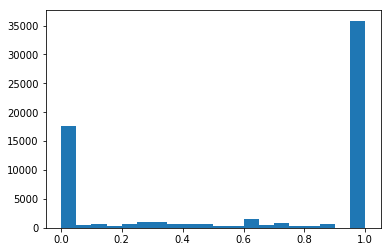

In [55]:
odf = df[0]
odf.isoSpecificity
plt.hist(odf.isoSpecificity, bins=20)

In [68]:
np.max(odf.iso_off_spots[~np.isnan(odf.iso_off_spots)].values)

0.0

In [70]:
Counter(odf.iso_off_spots)

Counter({0.0: 64585})

(array([    0.,     0.,     0.,     0.,     0., 64585.,     0.,     0.,
            0.,     0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <a list of 10 Patch objects>)

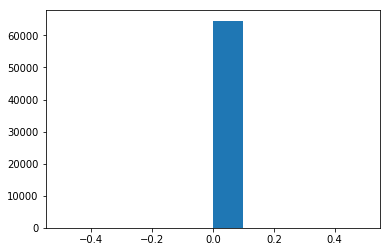

In [69]:
plt.hist(odf.iso_off_spots[~np.isnan(odf.iso_off_spots)].values)

In [41]:
df[0].columns

Index([u'experiment', u'pleft', u'ro1', u'ro2', u'pright', u'encodingRegion',
       u'seq', u'gene', u'tid', u'start', u'length', u'gc', u'tm',
       u'specificity', u'isoSpecificity', u'header', u'FPKM', u'iso_off_spots',
       u'gene_off_spots'],
      dtype='object')

(0, 400)

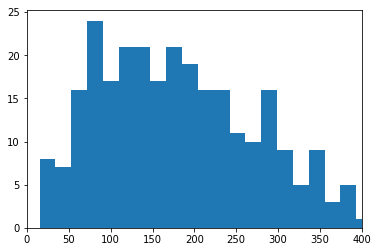

In [37]:
plt.hist(Counter(df[0].gene).values(), bins=50)
plt.xlim([0, 400])

In [197]:
%pdb

Automatic pdb calling has been turned ON


In [320]:
tid = 'ENST00000421587.6'
print(
df3[df3.tid==tid].ro1.unique(), 
df3[df3.tid==tid].ro2.unique(), 
df3[df3.tid==tid].ro3.unique())

(array(['RS64.0', 'RS0406', 'RS0095', 'RS156.0'], dtype=object), array(['RS0095', 'RS64.0', 'RS0406', 'RS156.0'], dtype=object), array(['RS156.0', 'RS64.0', 'RS0095', 'RS0406'], dtype=object))


In [118]:
df, primerL, primerR, readouts = parse_merfish_oligos('./calcium_cellType_oligos.fasta', 
                          counts_df=stringtie_counts, tid_column='transcript_id')
df2 = trim_oligos_to_fit(df, multi_transcripts_cutoff=192)
df3, fname, counts = balance_readouts(df2, primerL, primerR, readouts, per_tid=64, fa_out='/Users/rfor10/Downloads/mergos2.fa')


/Users/rfor10/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:58: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


CD24 44
ITPKA 35
EPCAM 29
P2RY11 40
SNAI2 39
CALM2 25
SNAI1 46
ORAI1 47
P2RX5 42
ACTA2 41
ERBB2 6
PICK1 46
INPP1 46


In [119]:
bit_ro_map = {
    'RS0095': 0, 
    'RS0109':1, 
    'RS0175': 2,
    'RS0237': 3, 
    'RS0307': 4, 
    'RS0332':5, 
    'RS0384':6, 
    'RS0406': 7, 
    'RS0451':8, 
    'RS0468':9,
    'RS0548':10, 
    'RS64.0':11, 
    'RS156.0':12,
    'RS278.0':13, 
    'RS313.0':14,
    'RS643.0':15, 
    'RS740.0':16, 
    'RS810.0':17
}



barcodes = {}
for n, c in counts.items():
    barcode = np.zeros(18)
    for rs in c.keys():
        barcode[bit_ro_map[rs]] = 1
    bstr = ''
    for i in barcode:
        bstr+=str(int(i))
    barcodes[n] = bstr

In [122]:
counts['ENST00000261769.9']

Counter({'RS0384': 48, 'RS0406': 48, 'RS156.0': 48, 'RS278.0': 48})

In [127]:
df2.columns

Index(['experiment', 'pleft', 'ro1', 'ro2', 'ro3', 'pright', 'encodingRegion',
       'seq', 'gene', 'tid', 'start', 'length', 'gc', 'tm', 'specificity',
       'isoSpecificity', 'header', 'FPKM', 'iso_off_spots', 'gene_off_spots'],
      dtype='object')

In [137]:
Counter(df2[df2.gene=='CD44'].ro2)

Counter({'RS0175': 25, 'RS0406': 21, 'RS0548': 30, 'RS643.0': 36})

In [131]:
barcodes['ENST00000296585.9']

'000000111100000000'

In [134]:
counts['ENST00000261769.9']

Counter({'RS0384': 48, 'RS0406': 48, 'RS156.0': 48, 'RS278.0': 48})

In [138]:
with open('./calcium_codebook_final.csv') as f:
    f.readline()
    f.readline()
    f.readline()
    f.readline()
    unused_bcodes = []
    for line in f.readlines():
        g, t, b = line.strip().split(',')
        if t not in barcodes:
            print(g, t)
            unused_bcodes.append(b)
            continue
        if barcodes[t]==b:
            continue
        else:
            if barcodes[t].count('1')==3:
                continue
            print(g, t, b, barcodes[t])

STIM2 ENST00000467011.5
PLCB3 ENST00000279230.10
PLCB2 ENST00000260402.7
PLCB2 ENST00000557821.5
PLCB2 ENST00000456256.6
ATP2A1 ENST00000395503.8
CD24 ENST00000606017.1
CD24 ENST00000619133.4
EpCAM ENST00000263735.8
ITPKA ENST00000260386.6
CALM2 ENST00000272298.11
RYR3 ENST00000634891.1
RYR3 ENST00000415757.7
RYR3 ENST00000389232.9
SLC24A1 ENST00000339868.10
RRM2 ENST00000615152.4
RRM2 ENST00000304567.9
ITPKB ENST00000429204.5
P2RX5 ENST00000345901.7
P2RX5 ENST00000225328.9
PPP3CB ENST00000394829.6
CD24 ENST00000606017.1
CD44 ENST00000263398.10 000001010000010100 001000010010000100
CD49f ENST00000264107.11 000000110011000000 001000010100100000
HER2 ENST00000541774.5
HER2 ENST00000269571.9
ITGA6 ENST00000264107.11 000000000101100010 001000010100100000
MME ENST00000460393.5 000000000101010100 000001010101000000
EpCAM ENST00000263735.8
GRK4 ENST00000398052.8


In [141]:
sorted(unused_bcodes)

['000000000011001001',
 '000000000011010001',
 '000000000101101000',
 '000000000101101000',
 '000001010000101000',
 '000100010010001000',
 '000100100100100000',
 '000100100100100000',
 '001010000010100000',
 '010000100010010000',
 '010000100010010000',
 '010000100100001000',
 '010010000001001000',
 '010010000001001000',
 '010010000001001000',
 '100001001000010000',
 '100010000001000100',
 '100010000010001000',
 '100010000100010000',
 '100010000100010000',
 '100010001000100000',
 '100101100000000000',
 '100101100000000000',
 '100101100000000000',
 '101010100000000000',
 '110000000000001100']

In [410]:
df2 = df2[df2.gene != 'EPCAM']


In [417]:
df2[df2.tid=='ENST00000606017.1'].gene.unique()

array([], dtype=object)

In [94]:
df3.shape

(10305, 20)

In [90]:
for idx, g in enumerate(df3.tid.unique()):
    c = Counter()
    c.update(df3[df3.tid==g].ro1)
    c.update(df3[df3.tid==g].ro2)
    c.update(df3[df3.tid==g].ro3)
    print(c)

Counter({'RS0095': 45, 'RS643.0': 43, 'RS0548': 41, 'RS0332': 36})
Counter({'RS278.0': 34, 'RS810.0': 29, 'RS0468': 28, 'RS643.0': 26})
Counter({'RS0384': 51, 'RS643.0': 49, 'RS0332': 48, 'RS156.0': 44})
Counter({'RS643.0': 52, 'RS156.0': 51, 'RS0095': 47, 'RS0237': 42})
Counter({'RS313.0': 52, 'RS64.0': 51, 'RS643.0': 46, 'RS0548': 43})
Counter({'RS0332': 50, 'RS0307': 49, 'RS0406': 47, 'RS0384': 46})
Counter({'RS740.0': 36, 'RS0548': 33, 'RS156.0': 31, 'RS278.0': 23})
Counter({'RS0109': 52, 'RS156.0': 50, 'RS313.0': 47, 'RS0237': 43})
Counter({'RS0451': 51, 'RS0548': 49, 'RS156.0': 46, 'RS313.0': 46})
Counter({'RS0406': 7, 'RS0468': 7, 'RS643.0': 7, 'RS0109': 6})
Counter({'RS0109': 53, 'RS0451': 49, 'RS0548': 45, 'RS0237': 45})
Counter({'RS156.0': 54, 'RS0237': 52, 'RS0406': 44, 'RS0451': 42})
Counter({'RS156.0': 2, 'RS313.0': 2, 'RS0095': 1, 'RS0175': 1})
Counter({'RS810.0': 38, 'RS0548': 34, 'RS643.0': 34, 'RS64.0': 32})
Counter({'RS810.0': 50, 'RS0548': 48, 'RS278.0': 47, 'RS740.0

In [95]:
g

'ENST00000619929.4'

In [276]:
df = pd.DataFrame(c2.items(), columns=['tid', 'oligos'])
df[df.oligos>48].shape

(171, 2)

In [ ]:
c.

In [170]:
%pdb

Automatic pdb calling has been turned ON


In [278]:
df3.shape


(11711, 20)

In [151]:
keep_genes = list(c.keys())
keep_genes += ['SNAI2', 'SNAI1', 'P2RY11', 'INPP1', 'ORAI1']

In [161]:
multi_transcripts_max_oligos = 164

df2.shape
        


(12402, 20)

In [156]:
c.most_common(10)

[('DGKZ', 238),
 ('CAMK2D', 200),
 ('RYR3', 192),
 ('ATP2B4', 192),
 ('PLCB2', 192),
 ('ITPK1', 188),
 ('PLCB3', 188),
 ('CAMK2G', 185),
 ('SLC25A25', 180),
 ('ITPKB', 175)]

# Remove oligos that are too non-specific or are isoform specific

## Gene off spots limited to 25 total per gene

## Isoform oligos that have less than 1 isoform off spot are removed to get down to number oligos to be synthesized on single array

In [12]:
readouts

{'RS0095': 'GAAGTGAGGTGATTGAGTGA',
 'RS0109': 'TGTGATGGAAGTTAGAGGGT',
 'RS0175': 'TGAAAGGAATGGGTTGTGGT',
 'RS0237': 'GGGTTGATTAGTGGTAGAAA',
 'RS0307': 'ATGTGGAGGGATTGAAGGAT',
 'RS0332': 'GGGAGAATGAGGTGTAATGT',
 'RS0384': 'GAGTGTGTGTTAAGGTAGGT',
 'RS0406': 'AGATGATGTAGTAGTAAGGG',
 'RS0451': 'TGGAGTAGTTGGTTGTTAGG',
 'RS0468': 'GTATAAGGTGATTGGTGGTG',
 'RS0548': 'GAGGGTTTGTAAGGTGAATA',
 'RS156.0': 'GGAGTAGGTTGATGTGTAGT',
 'RS278.0': 'TGAGAAGTGGTTGTAGAGTG',
 'RS313.0': 'GGGTTAGTAGGTTGTGGTGT',
 'RS64.0': 'GAAGTGAGGTGATTGAGTGA',
 'RS643.0': 'GAGGGTTTGTAAGGTGAATA',
 'RS740.0': 'GTATAAGGTGATTGGTGGTG',
 'RS810.0': 'TGAGTGTGTGTTAAGGTAGG'}

In [116]:
oligo_df = pd.DataFrame()
for t in df.tid.unique():
    sub = df[df.tid==t].iloc[:64]
    if sub.gene.unique() in ['CALM2', 'ITPKA', 'ACTA2']:
        print('Skipped', t)
        continue
    sub = sub[sub.gene_off_spots<25]
    oligo_df = oligo_df.append(sub, ignore_index=True)
counts = Counter(oligo_df.gene)

oligos_removed = 0
for g, c in counts.items():
    if c < 65:
        continue
    sub = oligo_df[oligo_df.gene==g]
    specific_idx = sub[sub.iso_off_spots>1]
    if specific_idx.shape[0]<64:
        continue
    else:
        oligo_df.drop(sub[sub.iso_off_spots<1].index, inplace=True)
#     sub.drop(specific_idx, inplace=True)
    oligos_removed += sub.shape[0]-specific_idx.shape[0]
counts = Counter(oligo_df.gene)



('Skipped', 'ENST00000260386.6')
('Skipped', 'ENST00000272298.11')
('Skipped', 'ENST00000224784.10')


In [124]:
c = Counter()
c[1] += 1
c[1]
c

Counter({1: 1})

In [128]:
for t in oligo_df.tid.unique():
    readout_count = Counter()
    for idx, row in oligo_df[oligo_df.tid==t].iterrows():
        readout_count[row.ro1]+=1
        readout_count[row.ro2]+=1
        readout_count[row.ro3]+=1
    print(t, np.amin(readout_count.values()))

('ENST00000544301.6', 34)
('ENST00000451813.6', 46)
('ENST00000273482.10', 45)
('ENST00000354600.9', 45)
('ENST00000467087.5', 20)
('ENST00000467011.5', 17)
('ENST00000465503.5', 29)
('ENST00000616714.4', 36)
('ENST00000300737.8', 47)
('ENST00000590949.5', 44)
('ENST00000373578.6', 42)
('ENST00000020945.3', 25)
('ENST00000244050.2', 30)
('ENST00000552014.5', 36)
('ENST00000373064.9', 38)
('ENST00000432073.6', 22)
('ENST00000265631.9', 44)
('ENST00000261892.10', 46)
('ENST00000339868.10', 38)
('ENST00000634891.1', 47)
('ENST00000415757.7', 44)
('ENST00000389232.9', 44)
('ENST00000366574.6', 38)
('ENST00000355481.8', 40)
('ENST00000360566.6', 44)
('ENST00000615152.4', 36)
('ENST00000304567.9', 25)
('ENST00000367558.5', 45)
('ENST00000408923.7', 36)
('ENST00000382788.7', 45)
('ENST00000394885.7', 41)
('ENST00000379066.5', 43)
('ENST00000600194.5', 32)
('ENST00000291281.8', 24)
('ENST00000595515.5', 43)
('ENST00000263125.9', 42)
('ENST00000295797.4', 45)
('ENST00000555082.5', 43)
('ENST000

In [130]:
oligo_df[oligo_df.tid=='ENST00000263398.10'].shape

(64, 19)

(0, 64)

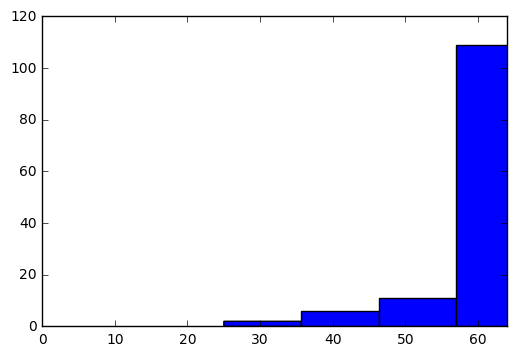

In [97]:
plt.hist(counts.values(), bins = 20)
plt.xlim(0, 64)

1184    0.0
1185    0.0
1186    0.0
1187    0.0
1188    0.0
1189    0.0
1190    0.0
1191    0.0
1192    0.0
1193    0.0
1194    0.0
1195    0.0
1196    0.0
1197    0.0
1198    0.0
1199    0.0
1200    0.0
1201    0.0
1202    0.0
1203    0.0
1204    0.0
1205    0.0
1206    0.0
1207    0.0
1208    0.0
1209    0.0
1210    0.0
1211    0.0
1212    0.0
1213    0.0
       ... 
1346    NaN
1347    NaN
1348    NaN
1349    NaN
1350    NaN
1351    NaN
1352    NaN
1353    NaN
1354    NaN
1355    NaN
1356    NaN
1357    NaN
1358    NaN
1359    NaN
1360    NaN
1361    NaN
1362    NaN
1363    NaN
1364    NaN
1365    NaN
1366    NaN
1367    NaN
1368    NaN
1369    NaN
1370    NaN
1371    NaN
1372    NaN
1373    NaN
1374    NaN
1375    NaN
Name: iso_off_spots, dtype: float64


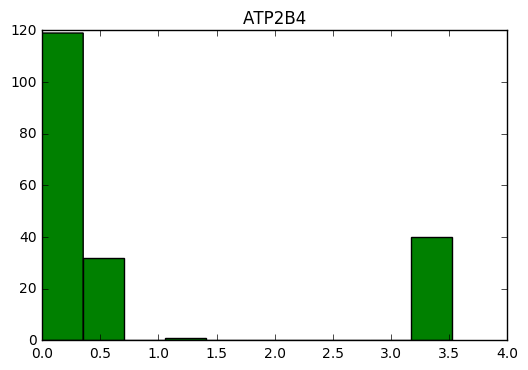

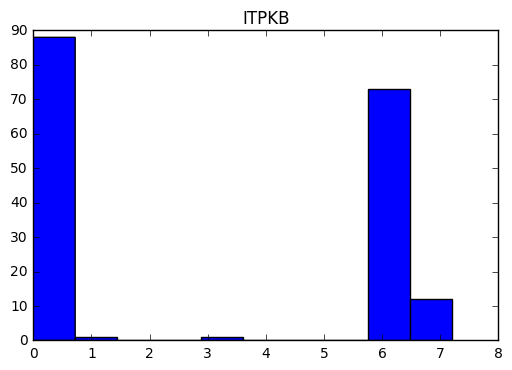

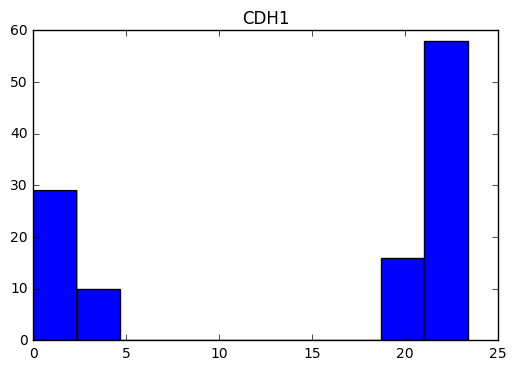

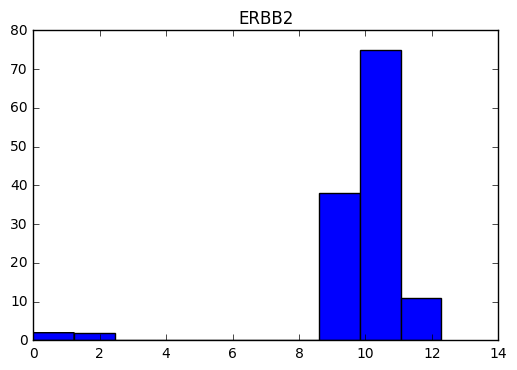

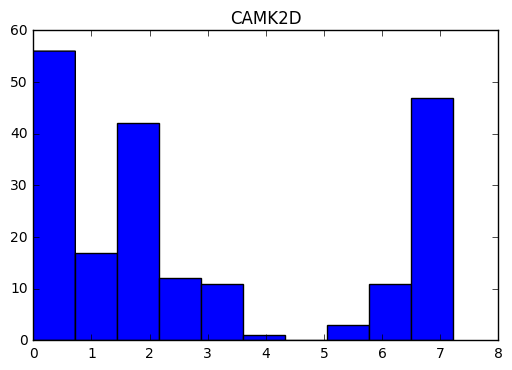

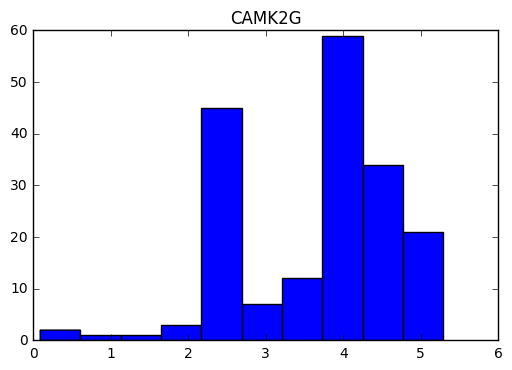

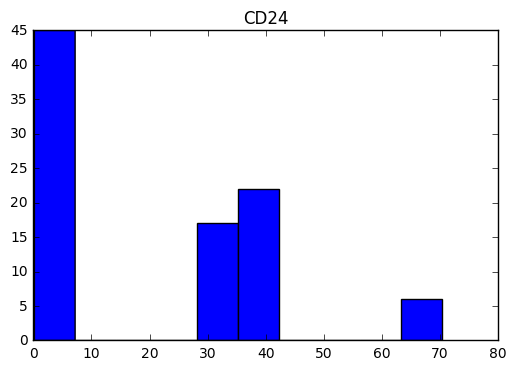

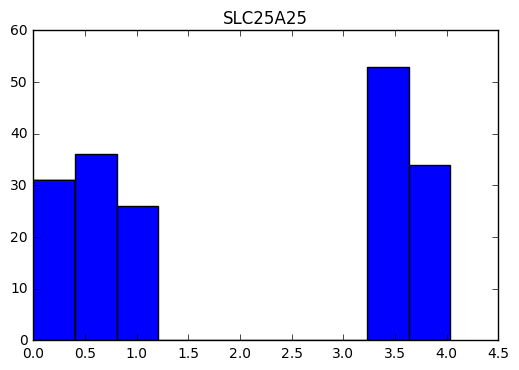

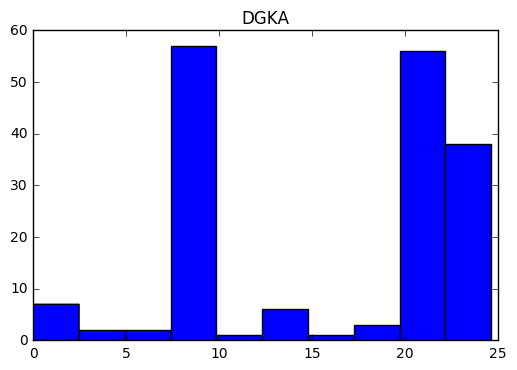

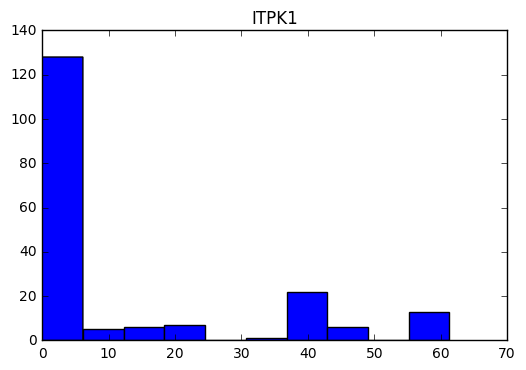

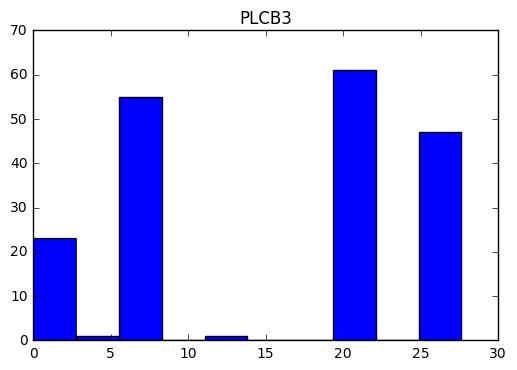

4015   NaN
4016   NaN
4017   NaN
4018   NaN
4019   NaN
4020   NaN
4021   NaN
4022   NaN
4023   NaN
4024   NaN
4025   NaN
4026   NaN
4027   NaN
4028   NaN
4029   NaN
4030   NaN
4031   NaN
4032   NaN
4033   NaN
4034   NaN
4035   NaN
4036   NaN
4037   NaN
4038   NaN
4039   NaN
4040   NaN
4041   NaN
4042   NaN
4043   NaN
4044   NaN
        ..
4177   NaN
4178   NaN
4179   NaN
4180   NaN
4181   NaN
4182   NaN
4183   NaN
4184   NaN
4185   NaN
4186   NaN
4187   NaN
4188   NaN
4189   NaN
4190   NaN
4191   NaN
4192   NaN
4193   NaN
4194   NaN
4195   NaN
4196   NaN
4197   NaN
4198   NaN
4199   NaN
4200   NaN
4201   NaN
4202   NaN
4203   NaN
4204   NaN
4205   NaN
4206   NaN
Name: iso_off_spots, dtype: float64


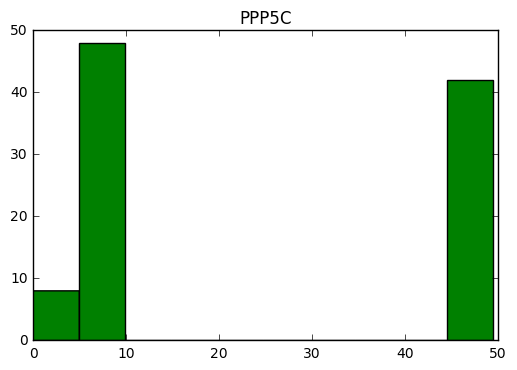

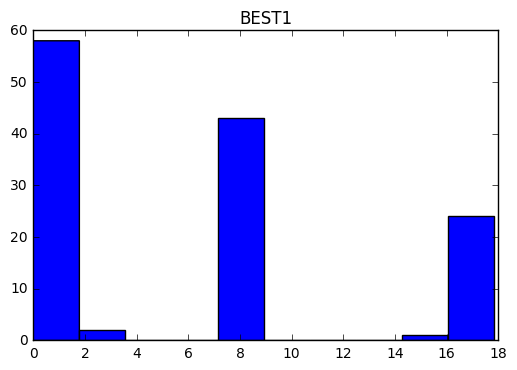

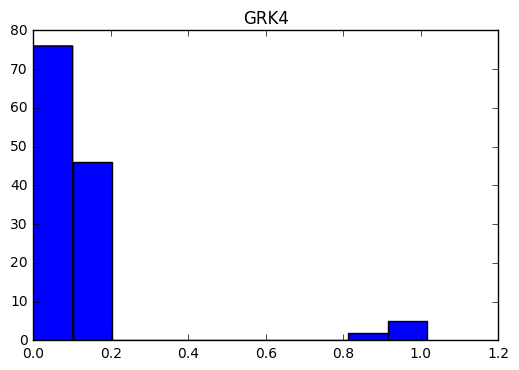

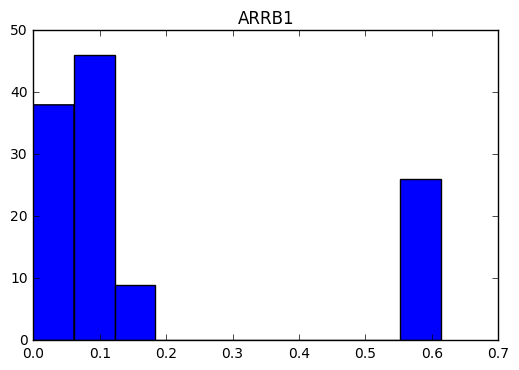

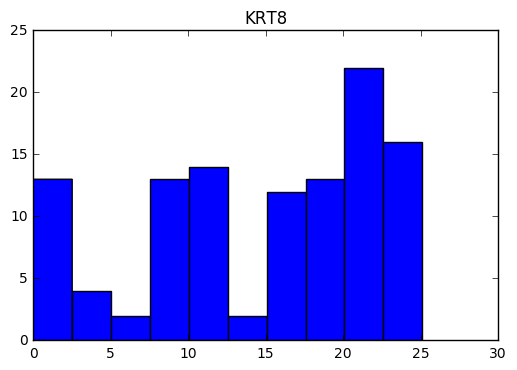

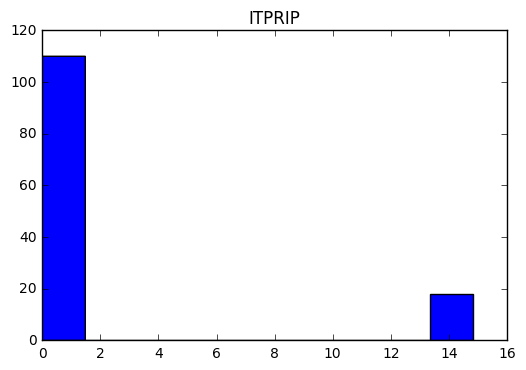

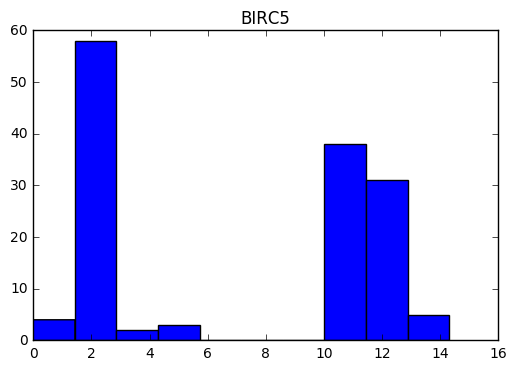

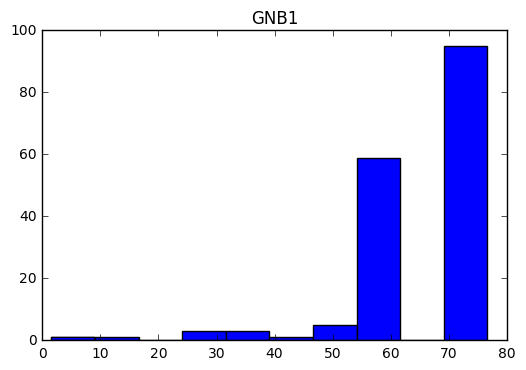

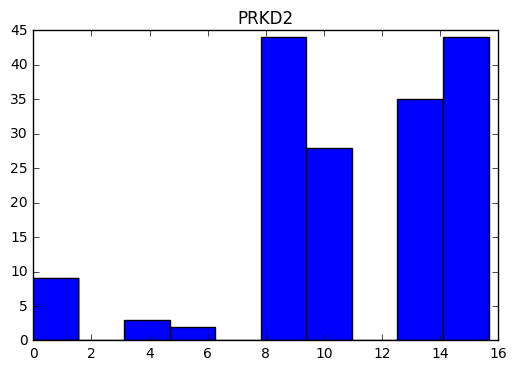

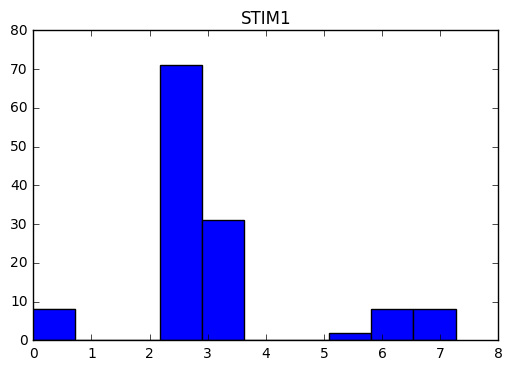

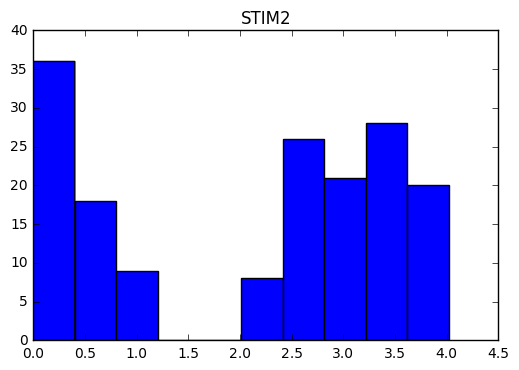

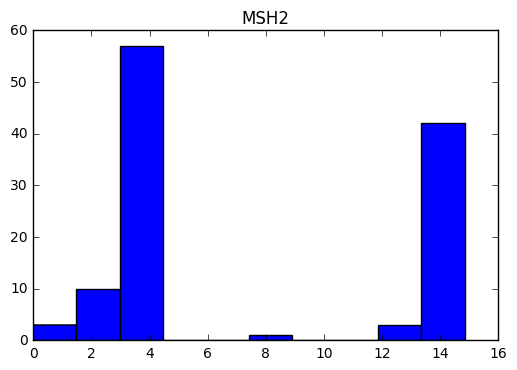

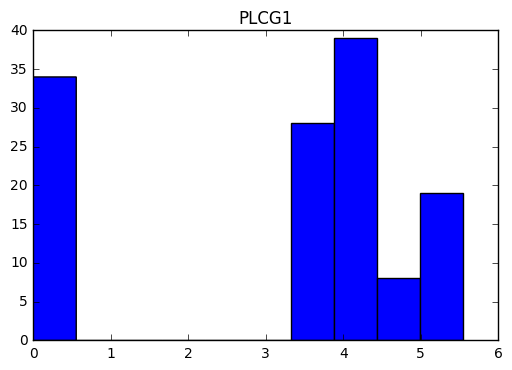

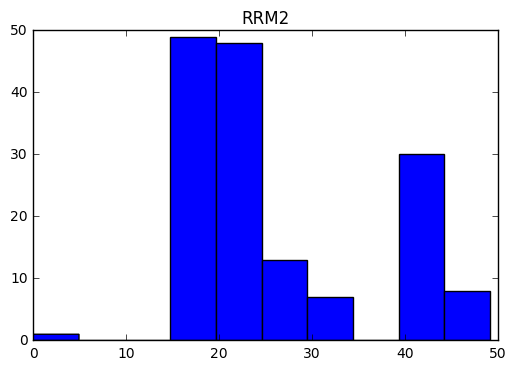

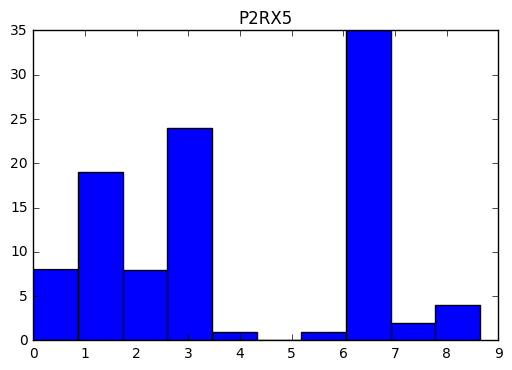

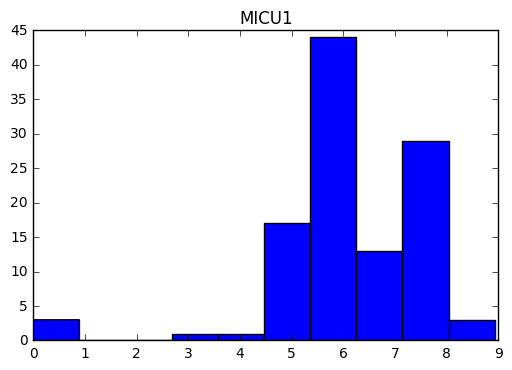

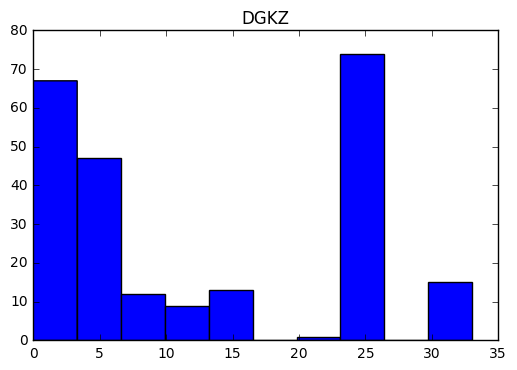

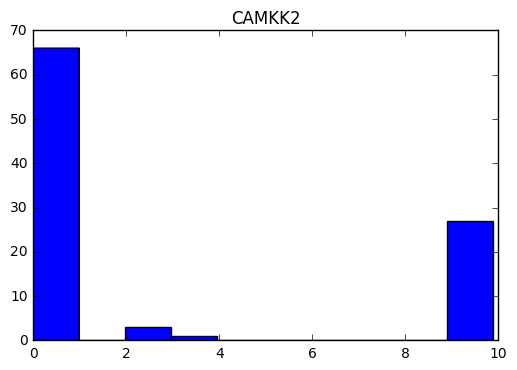

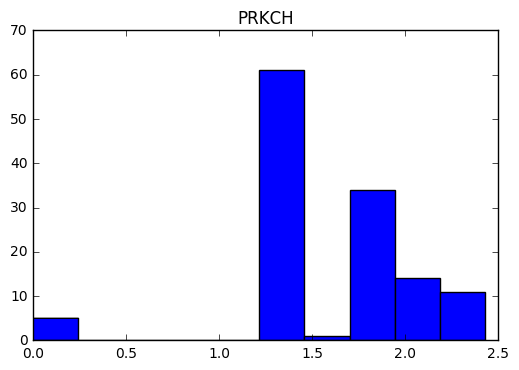

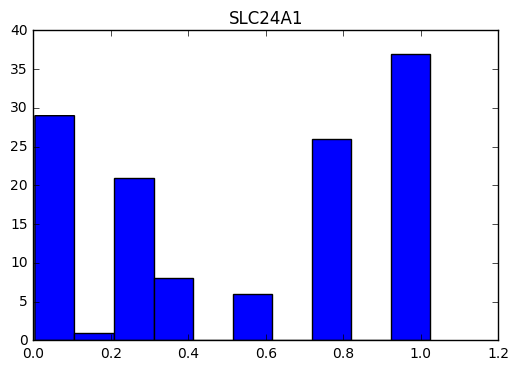

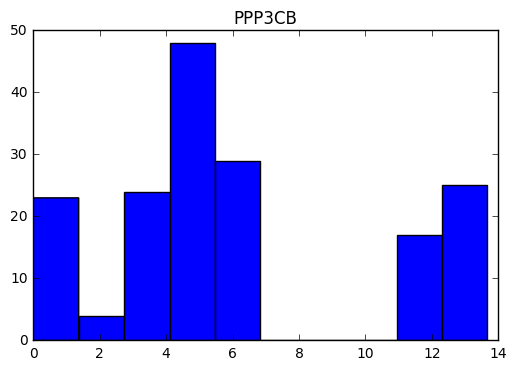

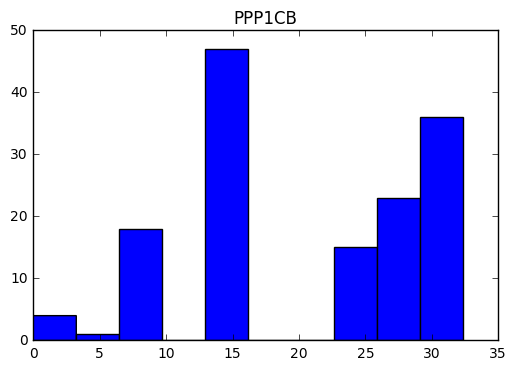

In [95]:
for k, v in counts.items():
    if v > 64:
        try:
            off_spots = oligo_df[oligo_df.gene==k].iso_off_spots
            plt.hist(off_spots)
            plt.title(k)
            plt.show()
        except:
            print(off_spots)

10
('RRM2', 157)
('RRM2', 157)
('RRM2', 157)
('P2RY11', 43)
('P2RY11', 43)
('P2RY11', 43)
('ORAI3', 55)
('ORAI3', 55)
('ORAI1', 47)
('ORAI1', 47)
('ORAI1', 47)
('ORAI1', 47)
('ORAI1', 47)
('ORAI1', 47)
('ORAI1', 47)
('KRT8', 118)
('KRT8', 118)
('KRT8', 118)
('KRT8', 118)
('KRT8', 118)
('KRT8', 118)
('KRT8', 118)
('KRT8', 118)
('KRT8', 118)
('KRT8', 118)
('KRT8', 118)
('KRT8', 118)
('ITPKB', 175)
('GNB1', 169)
('CD24', 90)
('CD24', 90)
('CD24', 90)
('CD24', 90)
('CD24', 90)
('CD24', 90)
('CD24', 90)
('CD24', 90)
('ACTA2', 41)
20
('RRM2', 157)
('ORAI1', 47)
('ORAI1', 47)
('ORAI1', 47)
('ORAI1', 47)
('KRT8', 118)
('KRT8', 118)
('KRT8', 118)
('KRT8', 118)
('KRT8', 118)
('KRT8', 118)
('KRT8', 118)
('GNB1', 169)
30
('RRM2', 157)
('ORAI1', 47)
('ORAI1', 47)
('ORAI1', 47)
('KRT8', 118)
('KRT8', 118)
('KRT8', 118)
('KRT8', 118)
('KRT8', 118)
('KRT8', 118)
('GNB1', 169)
40
('RRM2', 157)
('ORAI1', 47)
('ORAI1', 47)
('KRT8', 118)
('KRT8', 118)
('KRT8', 118)
('KRT8', 118)
('KRT8', 118)
50
('RRM2', 

In [4]:
with open('./human_sptbn1_PPP2CA_controls_oligos.fa', 'w') as f_out:
    df = pd.DataFrame(columns=['header', 'seq'])
    with open('./human_sptbn1_PPP2CA_controls_oligos.fasta') as f:
        output = []
        seq = ''
        for line in f.readlines():
            line.strip()
            if line[0] == '>':
                header = line
                f_out.write(header)
                if seq == '':
                    header = line
                else:
                    seqs=seq.strip().split(' ')
                    pleft = seqs[0]
                    readout1 = seqs[2]
                    if len(seqs[3])==20:
                        readout2 = seqs[3]
                        encoding = seqs[4]
                        readout3 = seqs[6]
                        pright = seqs[7]
        
                        oligo = readout1+readout2+encoding+readout3+'\n'
                    else:
                        encoding = seqs[3]
                        readout2 = seqs[5]
                        readout3 = seqs[6]
                        pright = seqs[7]
                        oligo = readout1+encoding+readout2+readout3+'\n'
#                     print(readout1, readout2, encoding, readout3)
                    output.append({'header': header, 'seq': oligo})
                    seq = ''                    
            else:
                seq += line.strip('\n')
df = df.append(output, ignore_index=True)
            

                

In [6]:
df.to_csv('./human_sptbn1_PPP2CA_controls_oligos.csv')